In [1]:
# This is for compatibility with google colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MultiOmicsIntegration/comp-401

Mounted at /content/drive
/content/drive/MyDrive/MultiOmicsIntegration/comp-401


In [2]:
from multi_omics_integration.func import *
from multi_omics_integration.classification_pipeline import *
from multi_omics_integration.processing import *
from multi_omics_integration.evaluation import *
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import mannwhitneyu, wilcoxon
from sklearn.model_selection import RepeatedStratifiedKFold

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [3]:
%cd /content/drive/MyDrive/MultiOmicsIntegration/comp-401/notebooks

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/notebooks


# RNA, miRNA, Methylation (No feature selection)

## Preprocessing

In [ ]:
datasets = {
            'rna': '../data/breast/RNASeq.csv',
            'mirna': '../data/breast/miRNASeq.csv',
            'methylation': '../data/breast/Methylation.csv',
}

labels = '../data/breast/Clinical.csv'

In [ ]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (430, 20155)
mirna (430, 823)
methylation (430, 20106)


### Removing low-variance + null features

In [ ]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold(X, percentage=0.10):
    var_thr = VarianceThreshold(threshold=percentage) #Removing both constant and quasi-constant (less than 1% variance)

    X_new = var_thr.fit_transform(X)

    column_names = X.columns[var_thr.get_support()]

    return pd.DataFrame(X_new, columns=column_names)

In [ ]:
new_data = {}

for modality in data:
    new_data[modality] = variance_threshold(data[modality], percentage=0.05)
    print(modality, new_data[modality].shape)

rna (430, 19291)
mirna (430, 583)
methylation (430, 754)


In [ ]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in new_data:
    X[modality] = new_data[modality]
    X[modality] = X[modality].dropna(axis=1)
    print(modality, X[modality].shape)

rna (430, 19291)
mirna (430, 583)
methylation (430, 705)


In [ ]:
subtypes['PAM50'].value_counts()

LumA     229
LumB     100
Basal     71
Her2      30
Name: PAM50, dtype: int64

In [ ]:
enc = LabelEncoder()
y = enc.fit_transform(subtypes['PAM50'])
enc.inverse_transform([0, 1, 2, 3])

array(['Basal', 'Her2', 'LumA', 'LumB'], dtype=object)

## Base Learners

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1, sampling_strategy='all', replacement=True)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

estimator_names = [estimator[0] for estimator in estimators]

brca_scoring={'accuracy': 'accuracy', 'balanced_accuracy':'balanced_accuracy', 'f1': make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)}

In [ ]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})

In [ ]:
display(base_metrics_df['rna']), display(base_metrics_df['mirna']), display(base_metrics_df['methylation'])

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.888 +/- 0.036,0.824 +/- 0.074,0.884 +/- 0.040,0.972 +/- 0.034,0.600 +/- 0.226,0.952 +/- 0.017,0.770 +/- 0.121
balanced_random_forest,0.870 +/- 0.023,0.858 +/- 0.035,0.871 +/- 0.023,0.972 +/- 0.034,0.800 +/- 0.125,0.891 +/- 0.045,0.770 +/- 0.103
deep_nn,0.884 +/- 0.044,0.858 +/- 0.073,0.884 +/- 0.044,0.972 +/- 0.034,0.767 +/- 0.249,0.921 +/- 0.046,0.770 +/- 0.098
svc,0.912 +/- 0.024,0.889 +/- 0.032,0.910 +/- 0.026,0.972 +/- 0.034,0.833 +/- 0.105,0.952 +/- 0.017,0.800 +/- 0.110


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.816 +/- 0.017,0.747 +/- 0.061,0.811 +/- 0.024,0.930 +/- 0.062,0.500 +/- 0.279,0.886 +/- 0.056,0.670 +/- 0.117
balanced_random_forest,0.772 +/- 0.024,0.690 +/- 0.063,0.765 +/- 0.028,0.916 +/- 0.052,0.367 +/- 0.267,0.839 +/- 0.063,0.640 +/- 0.146
deep_nn,0.823 +/- 0.023,0.787 +/- 0.056,0.820 +/- 0.024,0.958 +/- 0.057,0.667 +/- 0.211,0.882 +/- 0.052,0.640 +/- 0.102
svc,0.816 +/- 0.031,0.775 +/- 0.077,0.811 +/- 0.039,0.958 +/- 0.057,0.633 +/- 0.287,0.878 +/- 0.053,0.630 +/- 0.103


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.833 +/- 0.050,0.791 +/- 0.057,0.830 +/- 0.053,0.958 +/- 0.034,0.633 +/- 0.067,0.882 +/- 0.045,0.690 +/- 0.156
balanced_random_forest,0.760 +/- 0.045,0.790 +/- 0.062,0.765 +/- 0.046,0.945 +/- 0.050,0.800 +/- 0.245,0.733 +/- 0.053,0.680 +/- 0.163
deep_nn,0.823 +/- 0.051,0.816 +/- 0.073,0.818 +/- 0.055,0.958 +/- 0.034,0.833 +/- 0.149,0.882 +/- 0.061,0.590 +/- 0.150
svc,0.830 +/- 0.040,0.808 +/- 0.053,0.830 +/- 0.040,0.972 +/- 0.034,0.700 +/- 0.125,0.860 +/- 0.049,0.700 +/- 0.084


(None, None, None)

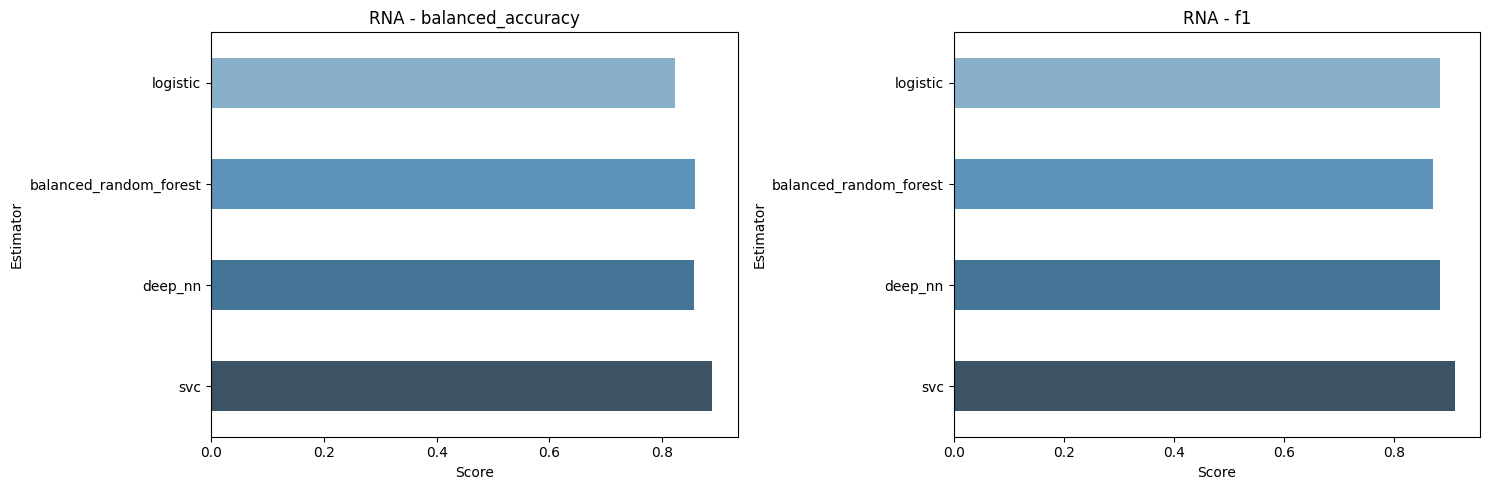

In [ ]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

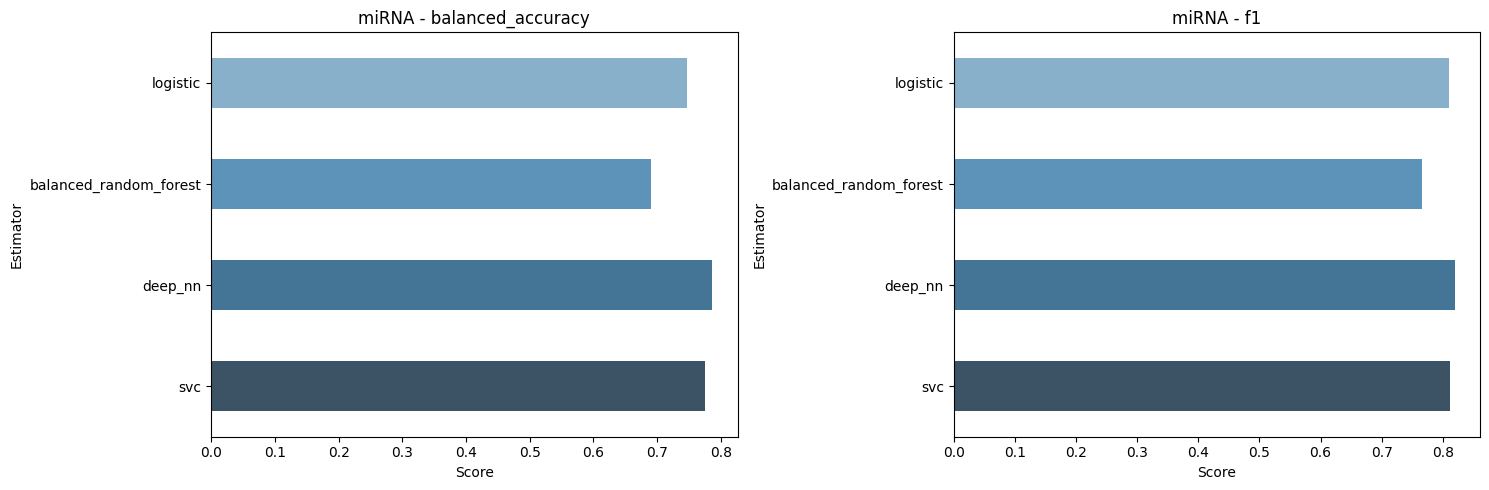

In [ ]:
plot_bar_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

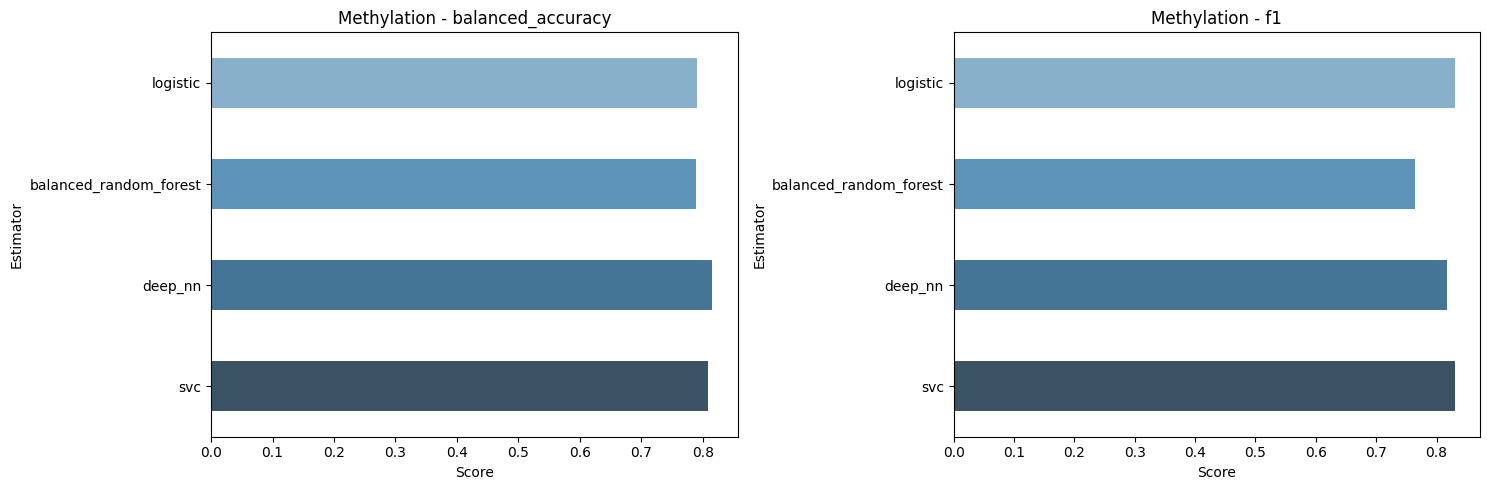

In [ ]:
plot_bar_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

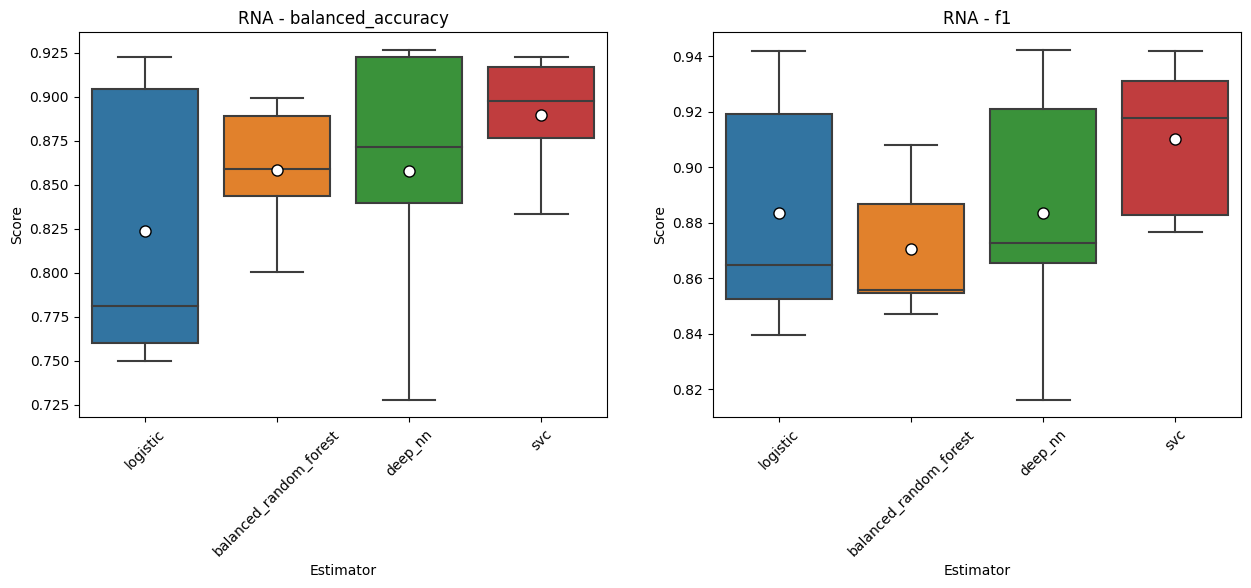

In [ ]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

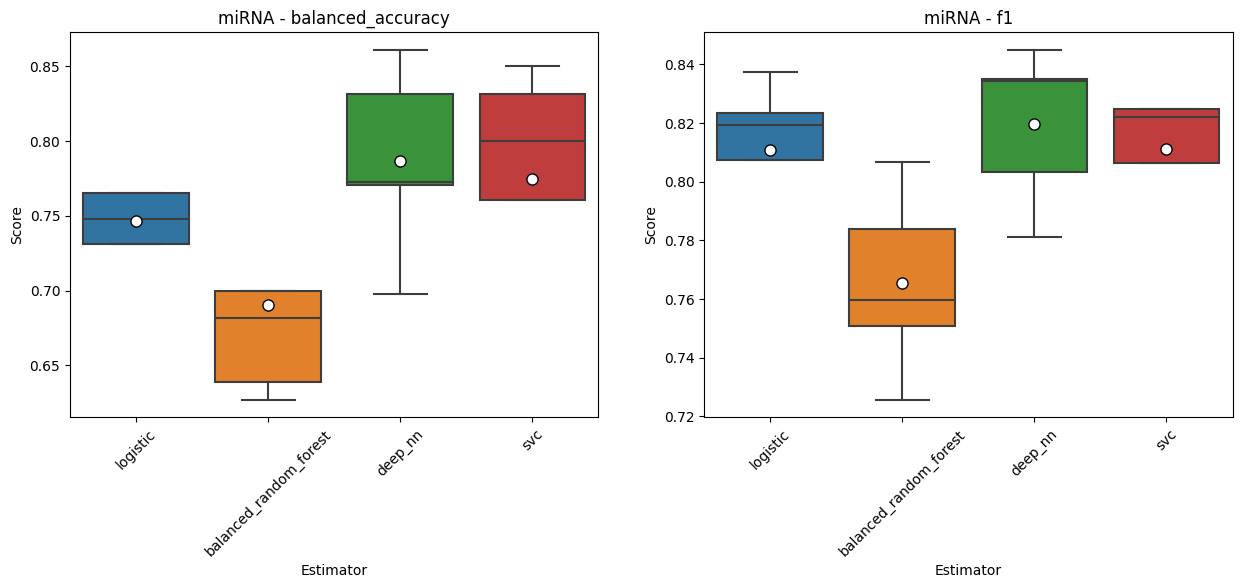

In [ ]:
plot_box_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

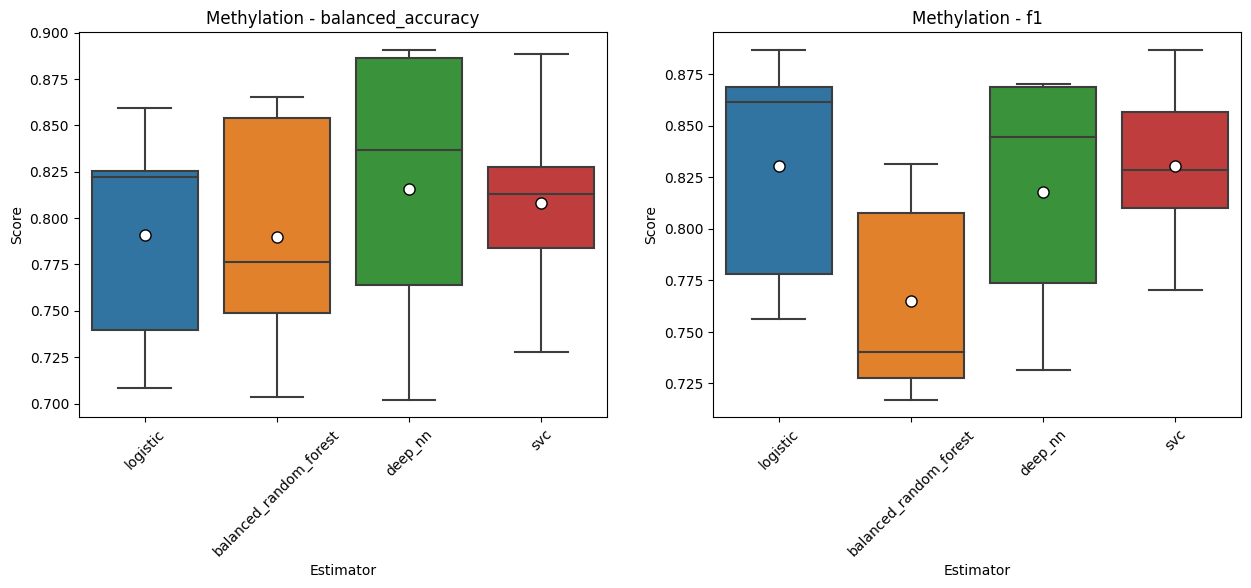

In [ ]:
plot_box_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

### Testing significance tests

In [ ]:
from scipy.stats import mannwhitneyu, wilcoxon
stat, p = mannwhitneyu(base_scores['rna'][0]['test_balanced_accuracy'], base_scores['rna'][3]['test_balanced_accuracy'])
print(p)
stat, p = wilcoxon(base_scores['rna'][0]['test_balanced_accuracy'], base_scores['rna'][3]['test_balanced_accuracy'])
print(p)

0.345741825860727
0.06788915486182899


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [ ]:
print(base_scores['mirna'][1])
print(base_scores['mirna'][2])

{'fit_time': array([1.12852001, 1.09547806, 1.10043502, 1.10665011, 1.08517408]), 'score_time': array([0.07238817, 0.07504416, 0.08146596, 0.07807064, 0.07814693]), 'test_accuracy': array([0.76744186, 0.73255814, 0.80232558, 0.79069767, 0.76744186]), 'test_balanced_accuracy': array([0.62707039, 0.63902692, 0.80414079, 0.69981884, 0.68194444]), 'test_f1': array([0.75084553, 0.72564433, 0.80655795, 0.78379558, 0.75961947]), 'test_recall (Basal)': array([0.92857143, 0.92857143, 0.85714286, 1.        , 0.86666667]), 'test_recall (Her2)': array([0.16666667, 0.16666667, 0.83333333, 0.16666667, 0.5       ]), 'test_recall (LumA)': array([0.91304348, 0.76086957, 0.82608696, 0.7826087 , 0.91111111]), 'test_recall (LumB)': array([0.5 , 0.7 , 0.7 , 0.85, 0.45])}
{'fit_time': array([1.49437404, 1.62711287, 1.59691   , 1.56278396, 1.56324887]), 'score_time': array([0.07366896, 0.04335523, 0.05248284, 0.05000114, 0.05397201]), 'test_accuracy': array([0.79069767, 0.80232558, 0.8372093 , 0.8372093 , 0.

In [ ]:
stat, p = mannwhitneyu(base_scores['mirna'][1]['test_recall (Her2)'], base_scores['rna'][2]['test_recall (Her2)'])
print(p)

0.07048462904621097


In [ ]:
from mlxtend.evaluate import paired_ttest_5x2cv

t, p = paired_ttest_5x2cv(estimator1=estimators[0][1],
                          estimator2=estimators[3][1],
                          X=X['rna'], y=y, scoring='balanced_accuracy', random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -1.272
p value: 0.259


In [ ]:
from mlxtend.evaluate import paired_ttest_5x2cv

t, p = paired_ttest_5x2cv(estimator1=estimators[1][1],
                          estimator2=estimators[2][1],
                          X=X['mirna'], y=y, scoring='balanced_accuracy', random_seed=2)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -1.431
p value: 0.212


In [ ]:
t, p = paired_ttest_5x2cv(estimator1=estimators[1][1],
                          estimator2=RandomForestClassifier(),
                          X=X['mirna'], y=y, scoring='balanced_accuracy', random_seed=2)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 2.050
p value: 0.096


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

results_model_1 = cross_val_score(estimators[1][1], X['mirna'], y, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1), scoring='balanced_accuracy')
results_model_2 = cross_val_score(estimators[2][1], X['mirna'], y, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1), scoring='balanced_accuracy')
results_model_3 = cross_val_score(RandomForestClassifier(), X['mirna'], y, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1), scoring='balanced_accuracy')

In [ ]:
print(results_model_1.mean())
print(results_model_2.mean())
print(results_model_3.mean())

0.7329064872325742
0.7653236714975846
0.6076718426501035


In [ ]:
print(results_model_1.mean())
print(results_model_2.mean())
print(results_model_3.mean())

0.7142627099148838
0.7577587991718426
0.6010668428317169


In [ ]:
from scipy.stats import wilcoxon
# Calculate p value
stat, p = wilcoxon(results_model_1, results_model_2, zero_method='zsplit')
print(p)
stat, p = wilcoxon(results_model_1, results_model_3, zero_method='zsplit')
print(p)

0.02734375
0.001953125


In [ ]:
from scipy.stats import wilcoxon
# Calculate p value
stat, p = wilcoxon(results_model_1, results_model_2, zero_method='zsplit')
print(p)
stat, p = wilcoxon(results_model_1, results_model_3, zero_method='zsplit')
print(p)

0.00201416015625
6.103515625e-05


In [ ]:
results_model_1 = cross_val_score(estimators[1][1], X['mirna'], y, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1), scoring='balanced_accuracy')
results_model_2 = cross_val_score(estimators[2][1], X['mirna'], y, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=2), scoring='balanced_accuracy')
results_model_3 = cross_val_score(RandomForestClassifier(), X['mirna'], y, cv=RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=3), scoring='balanced_accuracy')

In [ ]:
from scipy.stats import mannwhitneyu

print(results_model_1.mean())
print(results_model_2.mean())
print(results_model_3.mean())

# Calculate p value
stat, p = mannwhitneyu(results_model_1, results_model_2)
print(p)
stat, p = mannwhitneyu(results_model_1, results_model_3)
print(p)

0.7329064872325742
0.770877501725328
0.585628064727035
0.034433234736668046
2.0972605736125682e-05


In [ ]:
results_model_1 = cross_val_score(estimators[1][1], X['mirna'], y, cv=StratifiedKFold(n_splits=20, shuffle=True, random_state=1), scoring='balanced_accuracy')
results_model_2 = cross_val_score(estimators[2][1], X['mirna'], y, cv=StratifiedKFold(n_splits=20, shuffle=True, random_state=1), scoring='balanced_accuracy')

In [ ]:
results_model_3 = cross_val_score(RandomForestClassifier(), X['mirna'], y, cv=StratifiedKFold(n_splits=20, shuffle=True, random_state=1), scoring='balanced_accuracy')

In [ ]:
print(results_model_1.mean())
print(results_model_2.mean())
print(results_model_3.mean())


0.7643181818181819
0.7949621212121213
0.6178977272727273


In [ ]:
from scipy.stats import wilcoxon
# Calculate p value
stat, p = wilcoxon(results_model_1, results_model_2, zero_method='zsplit')
print(p)
stat, p = wilcoxon(results_model_1, results_model_3, zero_method='zsplit')
print(p)

0.287337268352032
8.20159912109375e-05


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


## Modality Ensembles

In [ ]:
from multi_omics_integration.classification_pipeline import Debugger

class ModalityPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_list=None, feature_select=None, final_estimator=LogisticRegression(random_state=0, n_jobs=-1), cv=5, n_jobs=-1, stack_method='auto'):
        self.cv = cv
        self.estimator_list = estimator_list
        self.feature_select = feature_select
        self.final_estimator = final_estimator
        self.n_jobs=n_jobs
        self.stack_method = stack_method

    def _get_model(self):
        self.cv_ = StratifiedKFold(n_splits=self.cv, random_state=0, shuffle=True)
        self.final_estimator_ = Pipeline([('imputer', SimpleImputer(strategy='median')), ('final', self.final_estimator)])

        stacking = StackingClassifier(estimators=self.estimator_list, final_estimator=self.final_estimator_, cv=self.cv_, stack_method=self.stack_method, n_jobs=self.n_jobs)

        if self.feature_select != None:
            model = Pipeline([('feature_selection', self.feature_select), ('clf', stacking)])
        else:
            model = stacking

        return model

    def fit(self, X, y):
        self.model_ = self._get_model()
        self.model_.fit(X, y)
        self.classes_ = self.model_.classes_
        self.coef_ = self.model_.final_estimator_.named_steps['final'].coef_

        return self

    def predict(self, X):
        return self.model_.predict(X)

    def predict_proba(self, X):
        return self.model_.predict_proba(X)

In [ ]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [ ]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})
    modality_metrics = pd.concat([modality_metrics, df])
    print(df)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

            accuracy balanced_accuracy               f1   recall (Basal)  \
rna  0.912 +/- 0.034   0.891 +/- 0.057  0.910 +/- 0.036  0.972 +/- 0.034   

       recall (Her2)    recall (LumA)    recall (LumB)  
rna  0.833 +/- 0.183  0.947 +/- 0.023  0.810 +/- 0.120  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the 

              accuracy balanced_accuracy               f1   recall (Basal)  \
mirna  0.821 +/- 0.022   0.779 +/- 0.041  0.814 +/- 0.026  0.958 +/- 0.057   

         recall (Her2)    recall (LumA)    recall (LumB)  
mirna  0.667 +/- 0.211  0.900 +/- 0.059  0.590 +/- 0.150  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

                    accuracy balanced_accuracy               f1  \
methylation  0.833 +/- 0.053   0.807 +/- 0.063  0.830 +/- 0.057   

              recall (Basal)    recall (Her2)    recall (LumA)  \
methylation  0.958 +/- 0.034  0.733 +/- 0.082  0.886 +/- 0.032   

               recall (LumB)  
methylation  0.650 +/- 0.161  


### Scoring

In [ ]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.912 +/- 0.034,0.891 +/- 0.057,0.910 +/- 0.036,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.810 +/- 0.120
mirna,0.821 +/- 0.022,0.779 +/- 0.041,0.814 +/- 0.026,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.590 +/- 0.150
methylation,0.833 +/- 0.053,0.807 +/- 0.063,0.830 +/- 0.057,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.032,0.650 +/- 0.161


In [ ]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]

all_scores = base_scores
all_scores['rna'].append(scores['rna'])
all_scores['mirna'].append(scores['mirna'])
all_scores['methylation'].append(scores['methylation'])

In [ ]:
all_metrics = {}

# Joining metrics together for visualization
for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [ ]:
# Balanced random forest and standard scaler with deep neural network
display(all_metrics['rna'], all_metrics['mirna'], all_metrics['methylation'])

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.888 +/- 0.036,0.824 +/- 0.074,0.884 +/- 0.040,0.972 +/- 0.034,0.600 +/- 0.226,0.952 +/- 0.017,0.770 +/- 0.121
balanced_random_forest,0.870 +/- 0.023,0.858 +/- 0.035,0.871 +/- 0.023,0.972 +/- 0.034,0.800 +/- 0.125,0.891 +/- 0.045,0.770 +/- 0.103
deep_nn,0.884 +/- 0.044,0.858 +/- 0.073,0.884 +/- 0.044,0.972 +/- 0.034,0.767 +/- 0.249,0.921 +/- 0.046,0.770 +/- 0.098
svc,0.912 +/- 0.024,0.889 +/- 0.032,0.910 +/- 0.026,0.972 +/- 0.034,0.833 +/- 0.105,0.952 +/- 0.017,0.800 +/- 0.110
rna,0.912 +/- 0.034,0.891 +/- 0.057,0.910 +/- 0.036,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.810 +/- 0.120


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.816 +/- 0.017,0.747 +/- 0.061,0.811 +/- 0.024,0.930 +/- 0.062,0.500 +/- 0.279,0.886 +/- 0.056,0.670 +/- 0.117
balanced_random_forest,0.772 +/- 0.024,0.690 +/- 0.063,0.765 +/- 0.028,0.916 +/- 0.052,0.367 +/- 0.267,0.839 +/- 0.063,0.640 +/- 0.146
deep_nn,0.823 +/- 0.023,0.787 +/- 0.056,0.820 +/- 0.024,0.958 +/- 0.057,0.667 +/- 0.211,0.882 +/- 0.052,0.640 +/- 0.102
svc,0.816 +/- 0.031,0.775 +/- 0.077,0.811 +/- 0.039,0.958 +/- 0.057,0.633 +/- 0.287,0.878 +/- 0.053,0.630 +/- 0.103
mirna,0.821 +/- 0.022,0.779 +/- 0.041,0.814 +/- 0.026,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.590 +/- 0.150


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.833 +/- 0.050,0.791 +/- 0.057,0.830 +/- 0.053,0.958 +/- 0.034,0.633 +/- 0.067,0.882 +/- 0.045,0.690 +/- 0.156
balanced_random_forest,0.760 +/- 0.045,0.790 +/- 0.062,0.765 +/- 0.046,0.945 +/- 0.050,0.800 +/- 0.245,0.733 +/- 0.053,0.680 +/- 0.163
deep_nn,0.823 +/- 0.051,0.816 +/- 0.073,0.818 +/- 0.055,0.958 +/- 0.034,0.833 +/- 0.149,0.882 +/- 0.061,0.590 +/- 0.150
svc,0.830 +/- 0.040,0.808 +/- 0.053,0.830 +/- 0.040,0.972 +/- 0.034,0.700 +/- 0.125,0.860 +/- 0.049,0.700 +/- 0.084
methylation,0.833 +/- 0.053,0.807 +/- 0.063,0.830 +/- 0.057,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.032,0.650 +/- 0.161


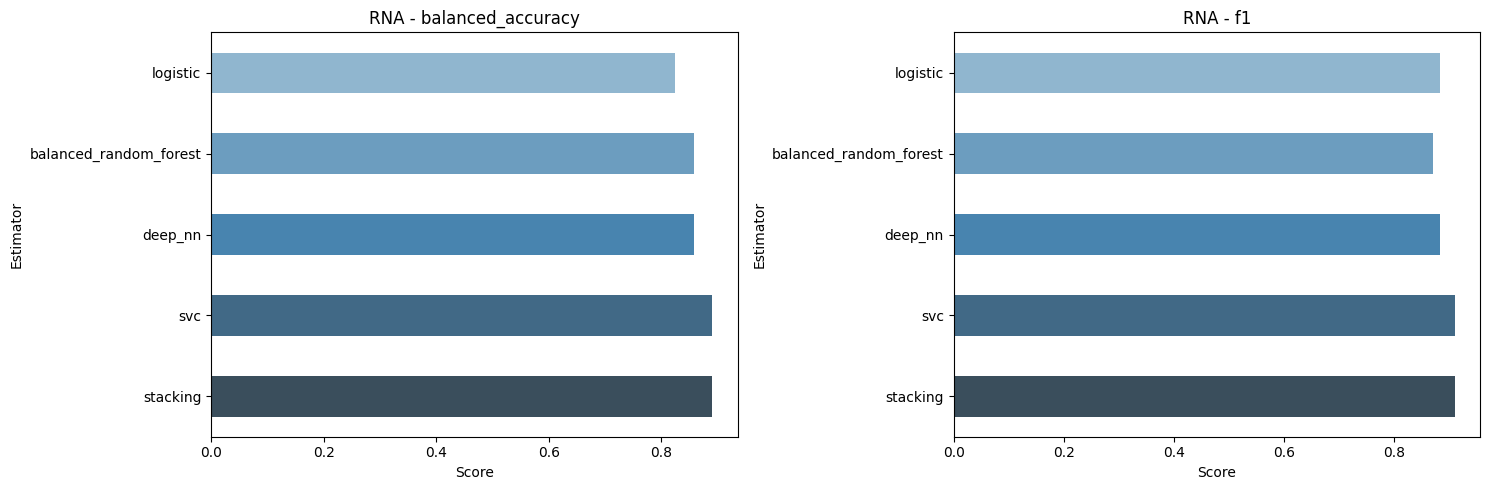

In [ ]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

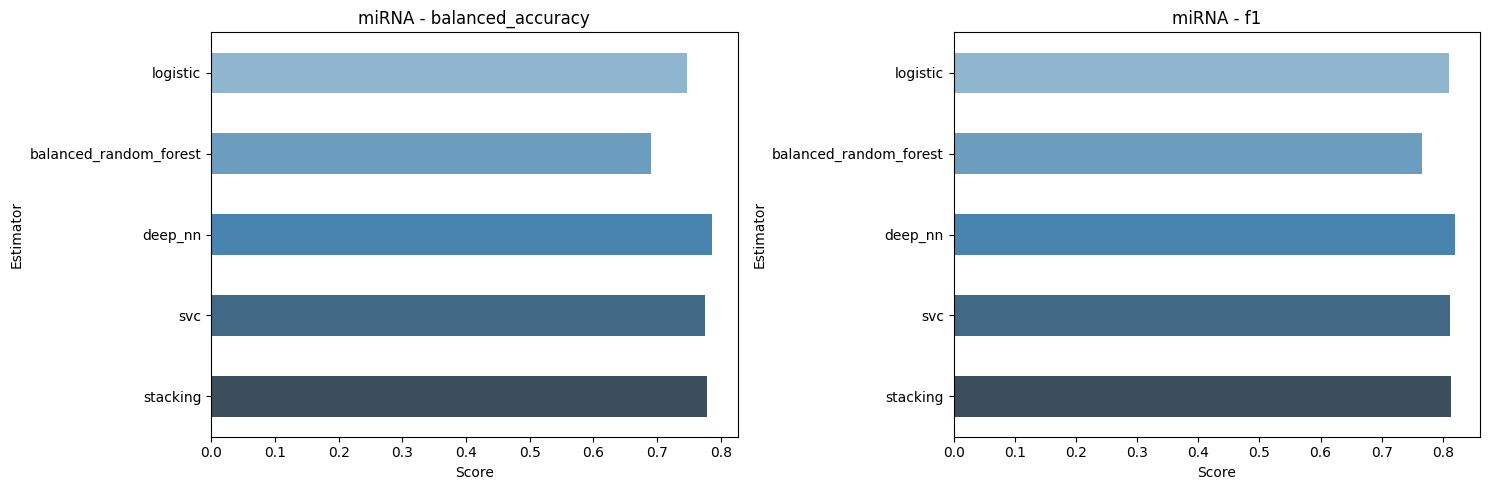

In [ ]:
plot_bar_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

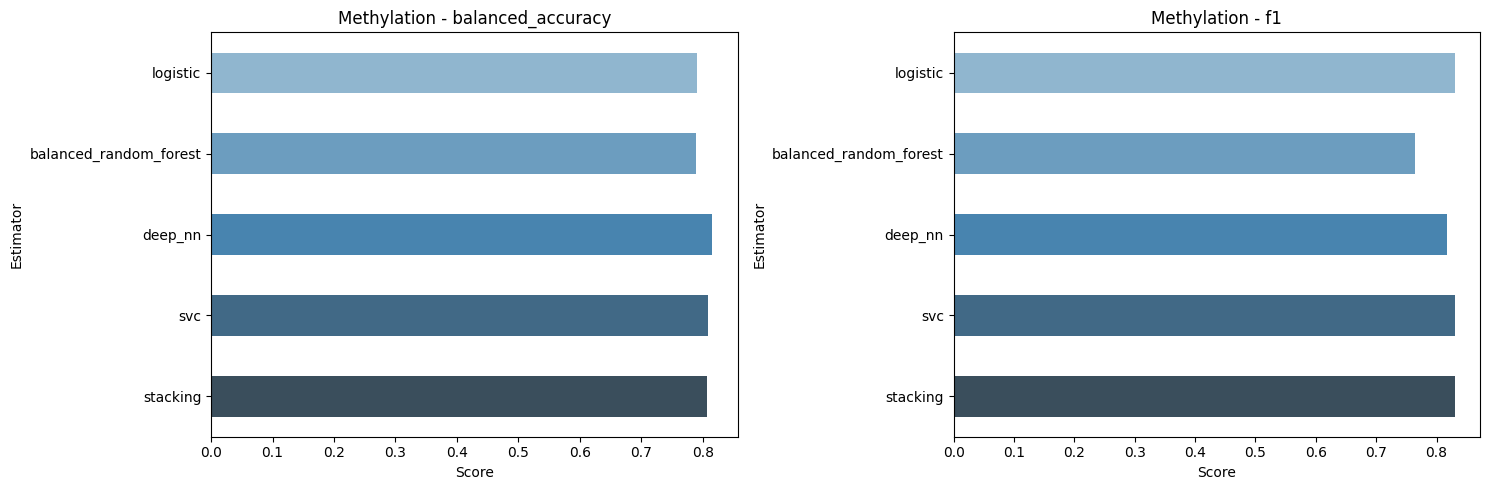

In [ ]:
plot_bar_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

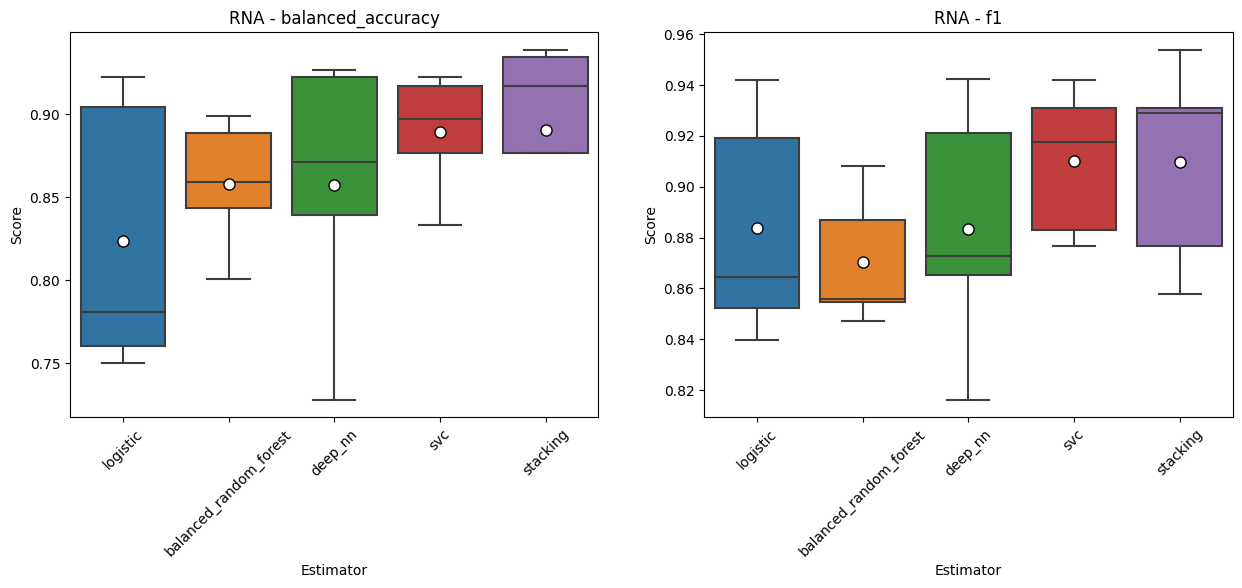

In [ ]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

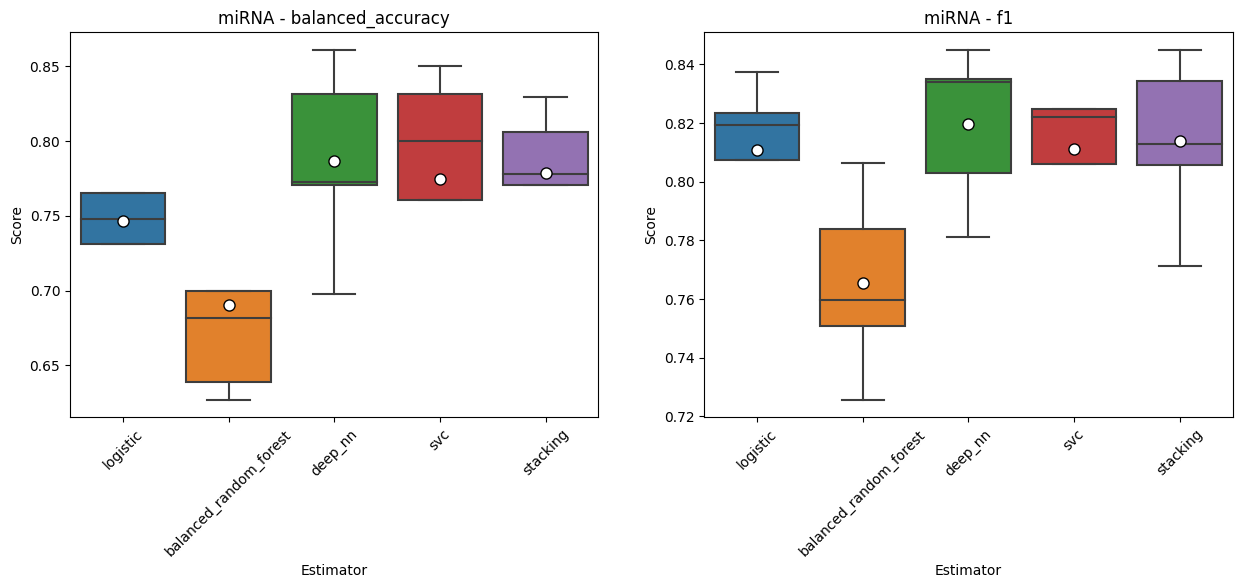

In [ ]:
plot_box_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

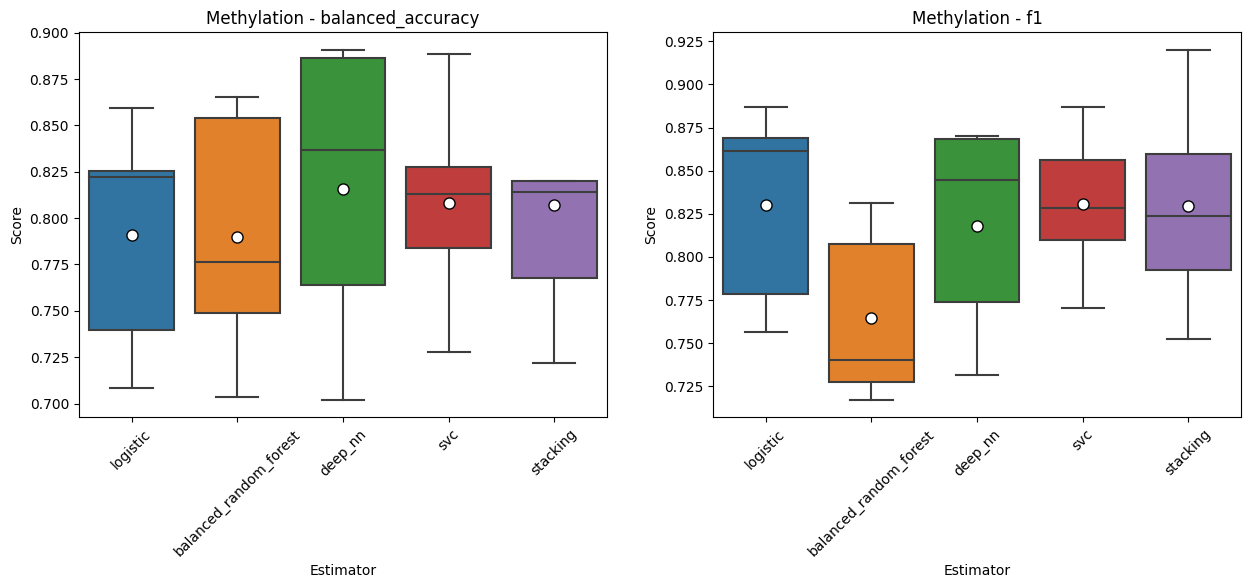

In [ ]:
plot_box_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

## Multi Omics Integration Ensemble

### Ensemble Model as a Custom Classifier

In [ ]:
from mlxtend.feature_selection import ColumnSelector

class MultiOmicsIntegrationClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_dict=None, feature_select=None, final_estimator=LogisticRegression(random_state=0, n_jobs=-1), stack_method='auto', cv=5, n_jobs=-1):
        # calculating scores
        self.estimator_dict = estimator_dict
        self.feature_select = feature_select
        self.final_estimator = final_estimator
        self.stack_method = stack_method
        self.cv = cv
        self.n_jobs = n_jobs

    def _get_pipeline(self):
        self.classifiers_ = []
        self.cv_ = StratifiedKFold(n_splits=self.cv, random_state=0, shuffle=True)

        for dataset, columns in self.column_names_.items():
            stacking = Pipeline([('column_selector', ColumnSelector(cols=columns)), ('modality_clf', self.estimator_dict[dataset])])
            self.classifiers_.append((dataset, stacking))

        self.final_estimator_ = Pipeline([('imputer', SimpleImputer(strategy='median')), ('final_estimator', self.final_estimator)])
        stacking = StackingClassifier(estimators=self.classifiers_, final_estimator=self.final_estimator_, cv=self.cv_, stack_method=self.stack_method, n_jobs=self.n_jobs)

        return stacking

    def fit(self, X, y, column_names=None, **fit_params):

        self.column_names_ = column_names

        self.pipeline_ = self._get_pipeline()
        self.pipeline_.fit(X, y)

        return self

    def predict(self, X):
        return self.pipeline_.predict(X)

    def predict_proba(self, X):
        return self.pipeline_.predict_proba(X)

In [ ]:
column_names = {}

for key in X.keys():
    column_names[key] = X[key].columns

In [ ]:
meta_ensembles = {}
meta_ensembles['rna + mirna + meth'] = MultiOmicsIntegrationClassifier(classifiers, cv=3)
meta_ensembles['mirna + meth'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['mirna', 'methylation']}, cv=3)
meta_ensembles['rna + mirna'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'mirna']}, cv=3)
meta_ensembles['rna + meth'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'methylation']}, cv=3)

In [ ]:
X_merged = {}
X_merged['rna + mirna + meth'] = pd.concat([X['rna'], X['mirna'], X['methylation']], axis=1, join='inner')
X_merged['mirna + meth'] = pd.concat([X['mirna'], X['methylation']], axis=1, join='inner')
X_merged['rna + mirna'] = pd.concat([X['rna'], X['mirna']], axis=1, join='inner')
X_merged['rna + meth'] = pd.concat([X['rna'], X['methylation']], axis=1, join='inner')


In [ ]:
integration_scores = {}
integration_metrics = {}

In [ ]:
integration_scores['rna + mirna + meth'], integration_metrics['rna + mirna + meth'] = get_cross_metrics(meta_ensembles['rna + mirna + meth'], X_merged['rna + mirna + meth'], y, name='rna + mirna + meth', cv=5, verbose=2, scoring=brca_scoring, fit_params={'column_names': column_names})

In [ ]:
integration_scores['mirna + meth'], integration_metrics['mirna + meth'] = get_cross_metrics(meta_ensembles['mirna + meth'], X_merged['mirna + meth'], y, name='mirna + meth', cv=5, verbose=2, scoring=brca_scoring, fit_params={'column_names': column_names})

In [ ]:
integration_scores['rna + mirna'], integration_metrics['rna + mirna'] = get_cross_metrics(meta_ensembles['rna + mirna'], X_merged['rna + mirna'], y, name='rna + mirna', cv=5, verbose=2, scoring=brca_scoring, fit_params={'column_names': column_names})

In [ ]:
integration_scores['rna + meth'], integration_metrics['rna + meth'] = get_cross_metrics(meta_ensembles['rna + meth'], X_merged['rna + meth'], y, name='rna + meth', cv=5, verbose=2, scoring=brca_scoring, fit_params={'column_names': column_names})

In [ ]:
class_integration_stacking_metrics = pd.concat([modality_metrics, integration_metrics.values()])
names = ['rna', 'cnv', 'rppa', 'rna + cnv + rppa', 'cnv + rppa', 'rna + rppa', 'rna + cnv']

class_integration = []
class_integration.append(scores['rna'])
class_integration.append(scores['cnv'])
class_integration.append(scores['rppa'])

for name, value in integration_scores.items():
    class_integration.append(value)

In [ ]:
class_integration_stacking_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.912 +/- 0.034,0.891 +/- 0.057,0.910 +/- 0.036,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.810 +/- 0.120
mirna,0.821 +/- 0.022,0.779 +/- 0.041,0.814 +/- 0.026,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.590 +/- 0.150
methylation,0.833 +/- 0.053,0.807 +/- 0.063,0.830 +/- 0.057,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.032,0.650 +/- 0.161
rna + mirna + meth,0.912 +/- 0.022,0.897 +/- 0.022,0.910 +/- 0.023,0.972 +/- 0.034,0.867 +/- 0.125,0.947 +/- 0.023,0.800 +/- 0.114
mirna + meth,0.851 +/- 0.021,0.826 +/- 0.031,0.849 +/- 0.020,0.958 +/- 0.057,0.767 +/- 0.133,0.908 +/- 0.054,0.670 +/- 0.081
rna + meth,0.914 +/- 0.020,0.898 +/- 0.027,0.912 +/- 0.022,0.972 +/- 0.034,0.867 +/- 0.125,0.952 +/- 0.017,0.800 +/- 0.105
rna + mirna,0.909 +/- 0.020,0.888 +/- 0.008,0.908 +/- 0.021,0.972 +/- 0.034,0.833 +/- 0.105,0.947 +/- 0.023,0.800 +/- 0.114


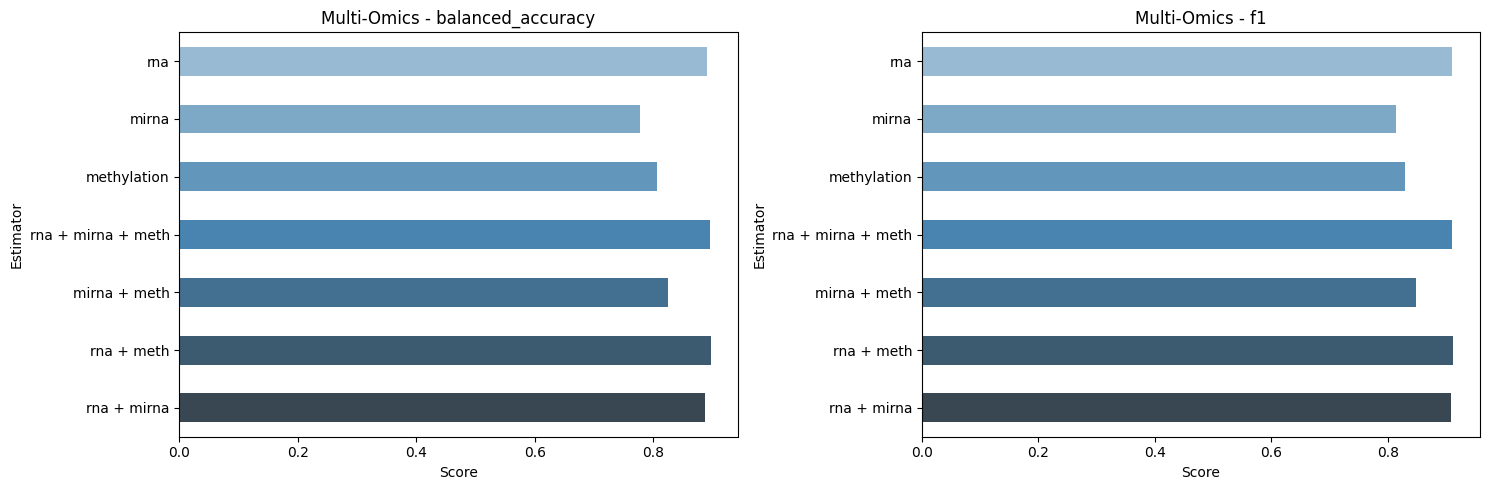

In [ ]:
plot_bar_scores(names, class_integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

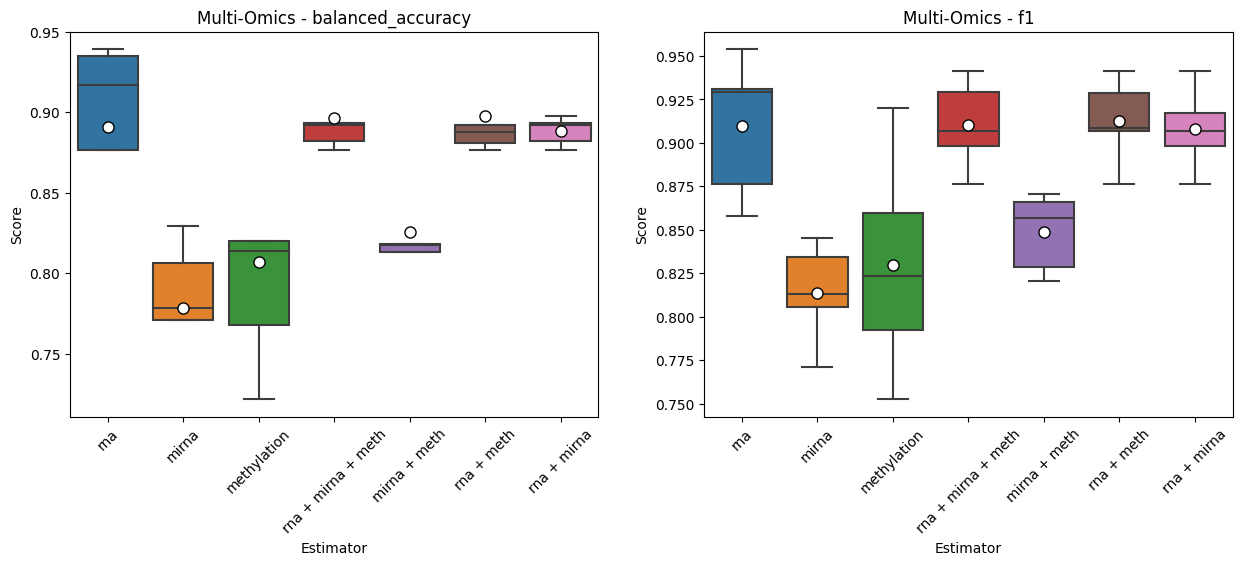

In [ ]:
plot_box_scores(names, class_integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [ ]:
meta_ensembles['rna + mirna + meth'].fit(X_merged['rna + mirna + meth'], y, column_names=column_names)
meta_ensembles['rna + mirna + meth'].pipeline_

StackingClassifier(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
                   estimators=[('rna',
                                Pipeline(steps=[('column_selector',
                                                 ColumnSelector(cols=Index(['A1BG_rna', 'A1CF_rna', 'A2BP1_rna', 'A2LD1_rna', 'A2ML1_rna',
       'A2M_rna', 'A4GALT_rna', 'A4GNT_rna', 'AAA1_rna', 'AAAS_rna',
       ...
       'ZWINT_rna', 'ZXDA_rna', 'ZXDB_rna', 'ZXDC_rna', 'ZYG11A_rna',
       'ZYG11B_rna', 'Z...
                                                                                                    StandardScaler()),
                                                                                                   ('mlpclassifier',
                                                                                                    MLPClassifier(random_state=0))])),
                                                                                  ('svc',
                                                                                   Pipeline(steps=[('standardscaler',
                                                                                                    StandardScaler()),
                                                                                                   ('svc',
                                                                                                    SVC(kernel='linear',
                                                                                                        max_iter=1000,
                                                                                                        random_state=0))]))]))]))],
                   final_estimator=Pipeline(steps=[('imputer',
                                                    SimpleImputer(strategy='median')),
                                                   ('final_estimator',
                                                    LogisticRegression(n_jobs=-1,
                                                                       random_state=0))]),
                   n_jobs=-1)

## Statistical Significance

Now that we see the results, we want to check if the performance differences between our multi-omics ensemble models and the modality ensemble models are significant. We can employ the Wilcoxen test, using multiple replications of cross-validation to get scores.

### Wilcoxen

In [ ]:
ensemble_results = {}
ensemble_metrics = {}

In [ ]:
def wilcoxen_test(name_1, name_2, scores_1, scores_2):

    stat, p = wilcoxon(scores_1, scores_2, alternative='greater')

    df = pd.Series({'estimator_1': name_1, 'estimator_2': name_2, 'statistic': stat, 'p': p, 'significant': p <= 0.05})

    return pd.DataFrame(df).T

In [ ]:
ensemble_results = {}
ensemble_metrics = {}

In [ ]:
ensemble_results['mirna + meth'], ensemble_metrics['mirna + meth'] = get_cross_metrics(meta_ensembles['mirna + meth'], X_merged['mirna + meth'], y, name='mirna + meth', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=brca_scoring, fit_params={'column_names': {key: column_names[key] for key in ['mirna', 'methylation']}})
ensemble_results['meth'], ensemble_metrics['meth'] = get_cross_metrics(classifiers['methylation'], X['methylation'], y, name='meth', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=brca_scoring)


NameError: name 'get_cross_metrics' is not defined

In [ ]:
ensemble_results['rna + mirna + meth'], ensemble_metrics['rna + mirna + meth'] = get_cross_metrics(meta_ensembles['rna + mirna + meth'], X_merged['rna + mirna + meth'], y, name='rna + mirna + meth', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=brca_scoring, fit_params={'column_names': column_names})
ensemble_results['rna'], ensemble_metrics['rna'] = get_cross_metrics(classifiers['rna'], X['rna'], y, name='rna', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=brca_scoring)

In [ ]:
# Picking models we want to compare performances for
compare = [
    ('mirna + meth', 'meth'),
    ('rna + mirna + meth', 'rna')
]

In [ ]:

wilcoxen_results = {}
metrics = ['balanced_accuracy', 'f1']

for metric in metrics:
    wilcoxen_results[metric] = pd.DataFrame()
    for est1, est2 in compare:
        df = wilcoxen_test(est1, est2, ensemble_results[est1]['test_' + metric], ensemble_results[est2]['test_' + metric])
        wilcoxen_results[metric] = pd.concat([wilcoxen_results[metric], df])


In [ ]:
display(wilcoxen_results['balanced_accuracy'], wilcoxen_results['f1'])

In [ ]:
plot_box_scores(['mirna + meth', 'meth'], [ensemble_results['mirna + meth'], ensemble_results['meth']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [ ]:
plot_box_scores(['rna + mirna + meth', 'rna'], [ensemble_results['rna + mirna + meth'], ensemble_results['rna']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [ ]:
import json
# Convert and write JSON object to file
with open("results/brca/brca_5x3_results.json", "w") as outfile:
    json.dump(ensemble_results, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

### Paired t-test

In [ ]:
from mlxtend.evaluate import paired_ttest_5x2cv

def p_value(estimator_1, estimator_2, X_1, X_2, y, scoring=make_scorer(f1_score, average='weighted'), random_seed=0, fit_params_1=None, fit_params_2=None):
    t, p = paired_ttest_5x2cv_custom(estimator_1[1], estimator_2[1], X_1, X_2, y, scoring=scoring, random_seed=random_seed, fit_params_1=fit_params_1, fit_params_2=fit_params_2)

    significant = p <= 0.05
    results = pd.DataFrame({'estimator_1': estimator_1[0], 'estimator_2': estimator_2[0], 'p': p, 'significant': significant}, index=[0])

    return results

In [ ]:
p_value_mirna_meth = p_value(('mirna + meth', meta_ensemble_mirna_meth), ('mirna', classifiers['mirna']),  pd.concat([X['mirna'], X['methylation']], axis=1, join='inner'), X['mirna'], y, fit_params_1={'column_names': {'mirna': X['mirna'].columns, 'methylation': X['methylation'].columns}})

In [ ]:
p_value_mirna_meth

# RNA, miRNA, Methylation (Feature Selection)

## Preprocessing

In [4]:
datasets = {
            'rna': '../data/breast/RNASeq.csv',
            'mirna': '../data/breast/miRNASeq.csv',
            'methylation': '../data/breast/Methylation.csv',
}

labels = '../data/breast/Clinical.csv'

In [5]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (430, 20155)
mirna (430, 823)
methylation (430, 20106)


### Removing low-variance + null features

In [6]:
!pip3 install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.7 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=d02e8c42b4c74c8092ddba8701a8d2058c38f6c91b7e09f2973bfae04040a33a
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [7]:
import scanpy as sc
from scanpy.pp import highly_variable_genes
import anndata as an

In [8]:
adata = {}

for modality in datasets:
  data[modality] = data[modality].dropna(axis=1)
  adata[modality] = an.AnnData(data[modality])

In [9]:
sc.pp.highly_variable_genes(adata['rna'], n_top_genes=1000)

In [10]:
sc.pp.highly_variable_genes(adata['mirna'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


In [11]:
sc.pp.highly_variable_genes(adata['methylation'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:276: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


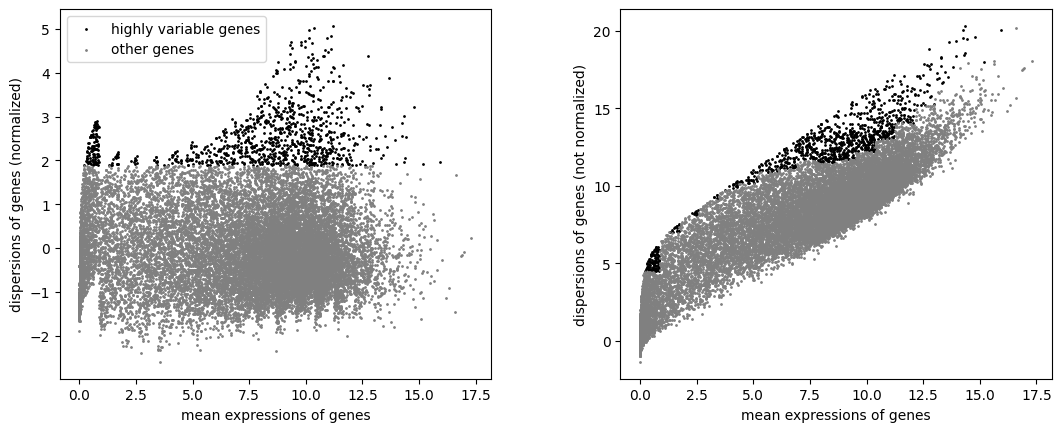

In [12]:
sc.pl.highly_variable_genes(adata['rna'])

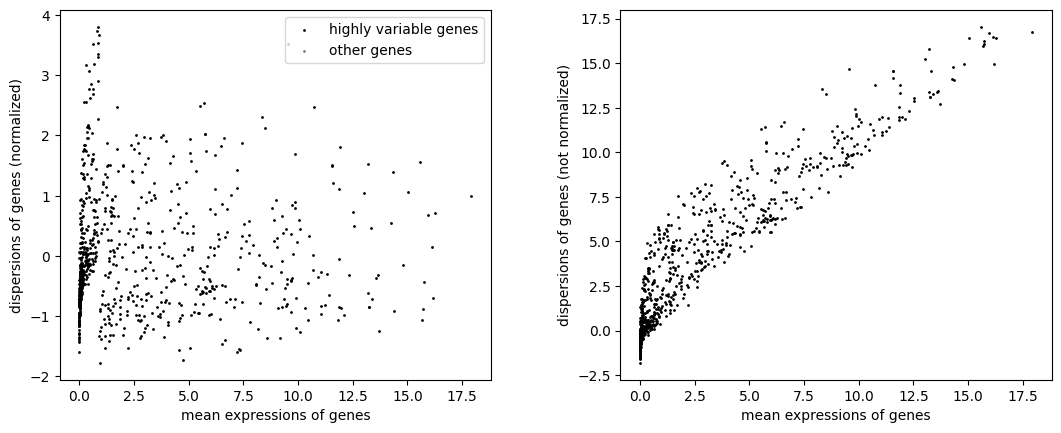

In [13]:
sc.pl.highly_variable_genes(adata['mirna'])

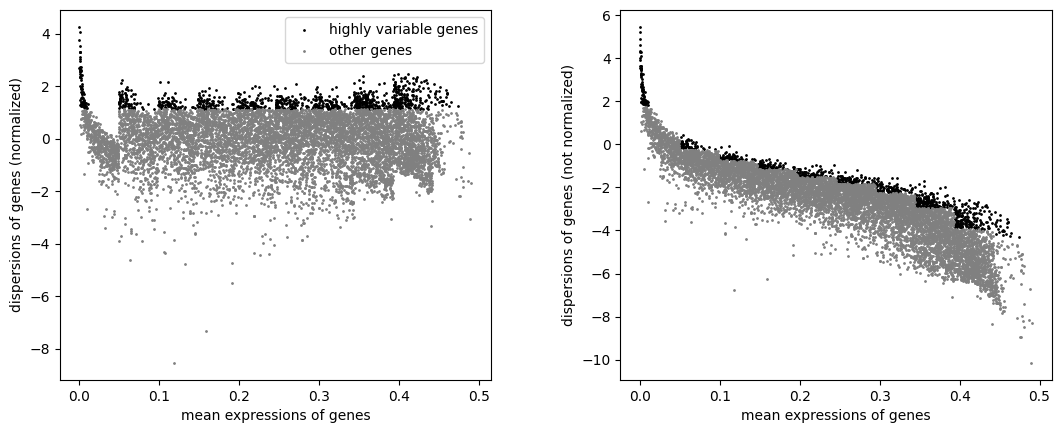

In [14]:
sc.pl.highly_variable_genes(adata['methylation'])

In [15]:
adata_new = {}

for modality in datasets:
  adata_new[modality] = adata[modality][:, adata[modality].var.highly_variable]
  sc.pp.scale(adata_new[modality], max_value=10)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [16]:
adata_new

{'rna': AnnData object with n_obs × n_vars = 430 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'mirna': AnnData object with n_obs × n_vars = 430 × 823
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'methylation': AnnData object with n_obs × n_vars = 430 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg'}

In [17]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in adata_new:
    X[modality] = adata_new[modality].to_df()
    print(modality, X[modality].shape)

rna (430, 1000)
mirna (430, 823)
methylation (430, 1000)


In [18]:
subtypes['PAM50'].value_counts()

PAM50
LumA     229
LumB     100
Basal     71
Her2      30
Name: count, dtype: int64

In [19]:
enc = LabelEncoder()
y = enc.fit_transform(subtypes['PAM50'])
enc.inverse_transform([0, 1, 2, 3])

array(['Basal', 'Her2', 'LumA', 'LumB'], dtype=object)

## Base Learners

In [20]:
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1, sampling_strategy='all', replacement=True)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

estimator_names = [estimator[0] for estimator in estimators]

brca_scoring={'accuracy': 'accuracy', 'balanced_accuracy':'balanced_accuracy', 'f1': make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)}

In [ ]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})

 25%|██▌       | 1/4 [00:10<00:31, 10.58s/it]

logistic                  accuracy balanced_accuracy               f1   recall (Basal)  \
logistic  0.870 +/- 0.028   0.853 +/- 0.047  0.869 +/- 0.029  0.972 +/- 0.034   

            recall (Her2)    recall (LumA)    recall (LumB)  
logistic  0.800 +/- 0.125  0.908 +/- 0.009  0.730 +/- 0.098  


 50%|█████     | 2/4 [00:14<00:13,  6.64s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.840 +/- 0.048   0.865 +/- 0.040  0.845 +/- 0.047   

                         recall (Basal)    recall (Her2)    recall (LumA)  \
balanced_random_forest  0.958 +/- 0.057  0.867 +/- 0.067  0.803 +/- 0.042   

                          recall (LumB)  
balanced_random_forest  0.830 +/- 0.117  


 75%|███████▌  | 3/4 [00:18<00:05,  5.46s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (Basal)  \
deep_nn  0.870 +/- 0.038   0.835 +/- 0.041  0.868 +/- 0.039  0.972 +/- 0.034   

           recall (Her2)    recall (LumA)    recall (LumB)  
deep_nn  0.700 +/- 0.125  0.908 +/- 0.036  0.760 +/- 0.116  


100%|██████████| 4/4 [00:19<00:00,  4.84s/it]


svc             accuracy balanced_accuracy               f1   recall (Basal)  \
svc  0.874 +/- 0.028   0.869 +/- 0.054  0.873 +/- 0.030  0.972 +/- 0.034   

       recall (Her2)    recall (LumA)    recall (LumB)  
svc  0.867 +/- 0.163  0.908 +/- 0.021  0.730 +/- 0.093  


 25%|██▌       | 1/4 [00:02<00:07,  2.46s/it]

logistic                  accuracy balanced_accuracy               f1   recall (Basal)  \
logistic  0.791 +/- 0.034   0.711 +/- 0.078  0.783 +/- 0.038  0.902 +/- 0.056   

            recall (Her2)    recall (LumA)    recall (LumB)  
logistic  0.467 +/- 0.306  0.887 +/- 0.042  0.590 +/- 0.097  


 50%|█████     | 2/4 [00:06<00:06,  3.11s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.795 +/- 0.024   0.745 +/- 0.040  0.791 +/- 0.023   

                         recall (Basal)    recall (Her2)    recall (LumA)  \
balanced_random_forest  0.945 +/- 0.050  0.533 +/- 0.287  0.843 +/- 0.029   

                          recall (LumB)  
balanced_random_forest  0.660 +/- 0.166  


 75%|███████▌  | 3/4 [00:09<00:03,  3.25s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (Basal)  \
deep_nn  0.781 +/- 0.045   0.687 +/- 0.055  0.768 +/- 0.049  0.930 +/- 0.045   

           recall (Her2)    recall (LumA)    recall (LumB)  
deep_nn  0.400 +/- 0.133  0.900 +/- 0.059  0.520 +/- 0.103  


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


svc             accuracy balanced_accuracy               f1   recall (Basal)  \
svc  0.798 +/- 0.036   0.732 +/- 0.069  0.791 +/- 0.039  0.916 +/- 0.052   

       recall (Her2)    recall (LumA)    recall (LumB)  
svc  0.533 +/- 0.267  0.887 +/- 0.042  0.590 +/- 0.073  


 25%|██▌       | 1/4 [00:03<00:09,  3.23s/it]

logistic                  accuracy balanced_accuracy               f1   recall (Basal)  \
logistic  0.821 +/- 0.033   0.774 +/- 0.033  0.819 +/- 0.033  0.958 +/- 0.034   

            recall (Her2)    recall (LumA)    recall (LumB)  
logistic  0.600 +/- 0.082  0.878 +/- 0.047  0.660 +/- 0.116  


 50%|█████     | 2/4 [00:08<00:08,  4.29s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.791 +/- 0.042   0.812 +/- 0.042  0.797 +/- 0.042   

                         recall (Basal)    recall (Her2)    recall (LumA)  \
balanced_random_forest  0.958 +/- 0.034  0.800 +/- 0.067  0.768 +/- 0.043   

                          recall (LumB)  
balanced_random_forest  0.720 +/- 0.093  


 75%|███████▌  | 3/4 [00:12<00:04,  4.05s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (Basal)  \
deep_nn  0.807 +/- 0.031   0.768 +/- 0.051  0.801 +/- 0.035  0.945 +/- 0.050   

           recall (Her2)    recall (LumA)    recall (LumB)  
deep_nn  0.667 +/- 0.149  0.882 +/- 0.058  0.580 +/- 0.147  


100%|██████████| 4/4 [00:12<00:00,  3.13s/it]

svc             accuracy balanced_accuracy               f1   recall (Basal)  \
svc  0.805 +/- 0.033   0.763 +/- 0.041  0.800 +/- 0.037  0.945 +/- 0.050   

       recall (Her2)    recall (LumA)    recall (LumB)  
svc  0.633 +/- 0.067  0.874 +/- 0.065  0.600 +/- 0.152  


In [ ]:
display(base_metrics_df['rna']), display(base_metrics_df['mirna']), display(base_metrics_df['methylation'])

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.870 +/- 0.028,0.853 +/- 0.047,0.869 +/- 0.029,0.972 +/- 0.034,0.800 +/- 0.125,0.908 +/- 0.009,0.730 +/- 0.098
balanced_random_forest,0.840 +/- 0.048,0.865 +/- 0.040,0.845 +/- 0.047,0.958 +/- 0.057,0.867 +/- 0.067,0.803 +/- 0.042,0.830 +/- 0.117
deep_nn,0.870 +/- 0.038,0.835 +/- 0.041,0.868 +/- 0.039,0.972 +/- 0.034,0.700 +/- 0.125,0.908 +/- 0.036,0.760 +/- 0.116
svc,0.874 +/- 0.028,0.869 +/- 0.054,0.873 +/- 0.030,0.972 +/- 0.034,0.867 +/- 0.163,0.908 +/- 0.021,0.730 +/- 0.093


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.791 +/- 0.034,0.711 +/- 0.078,0.783 +/- 0.038,0.902 +/- 0.056,0.467 +/- 0.306,0.887 +/- 0.042,0.590 +/- 0.097
balanced_random_forest,0.795 +/- 0.024,0.745 +/- 0.040,0.791 +/- 0.023,0.945 +/- 0.050,0.533 +/- 0.287,0.843 +/- 0.029,0.660 +/- 0.166
deep_nn,0.781 +/- 0.045,0.687 +/- 0.055,0.768 +/- 0.049,0.930 +/- 0.045,0.400 +/- 0.133,0.900 +/- 0.059,0.520 +/- 0.103
svc,0.798 +/- 0.036,0.732 +/- 0.069,0.791 +/- 0.039,0.916 +/- 0.052,0.533 +/- 0.267,0.887 +/- 0.042,0.590 +/- 0.073


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.821 +/- 0.033,0.774 +/- 0.033,0.819 +/- 0.033,0.958 +/- 0.034,0.600 +/- 0.082,0.878 +/- 0.047,0.660 +/- 0.116
balanced_random_forest,0.791 +/- 0.042,0.812 +/- 0.042,0.797 +/- 0.042,0.958 +/- 0.034,0.800 +/- 0.067,0.768 +/- 0.043,0.720 +/- 0.093
deep_nn,0.807 +/- 0.031,0.768 +/- 0.051,0.801 +/- 0.035,0.945 +/- 0.050,0.667 +/- 0.149,0.882 +/- 0.058,0.580 +/- 0.147
svc,0.805 +/- 0.033,0.763 +/- 0.041,0.800 +/- 0.037,0.945 +/- 0.050,0.633 +/- 0.067,0.874 +/- 0.065,0.600 +/- 0.152


(None, None, None)

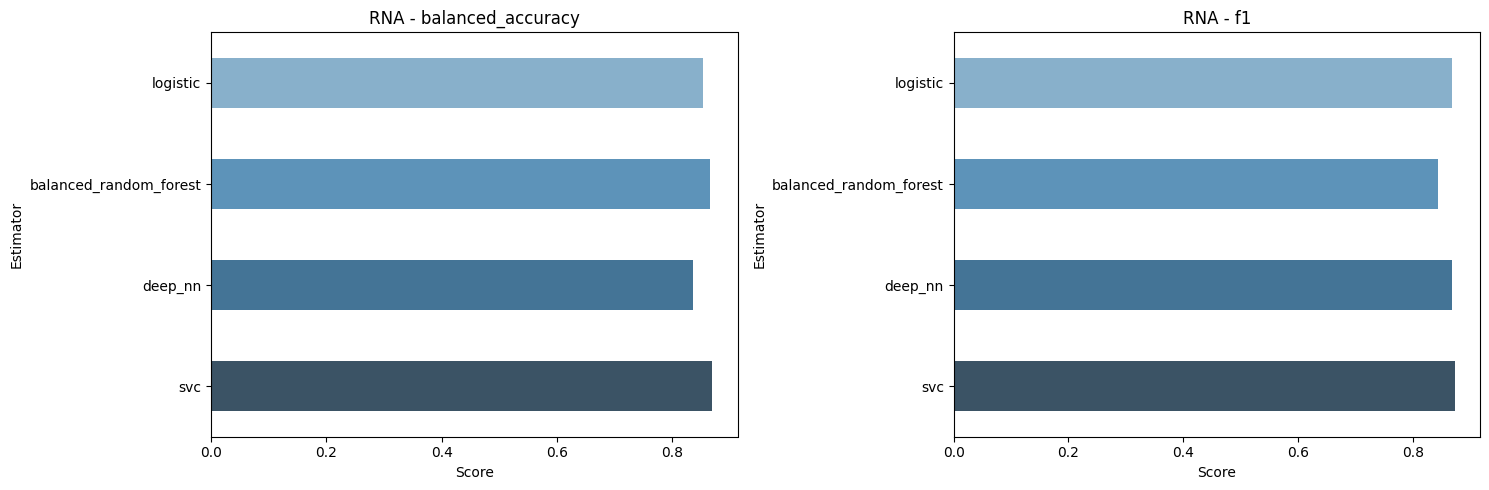

In [ ]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

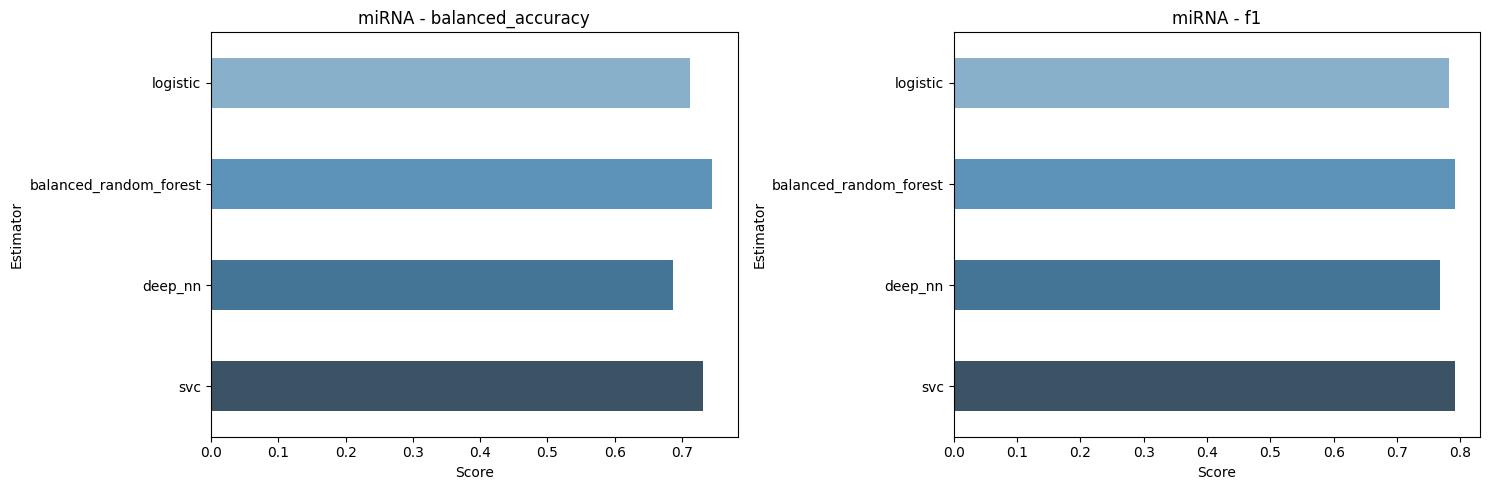

In [ ]:
plot_bar_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

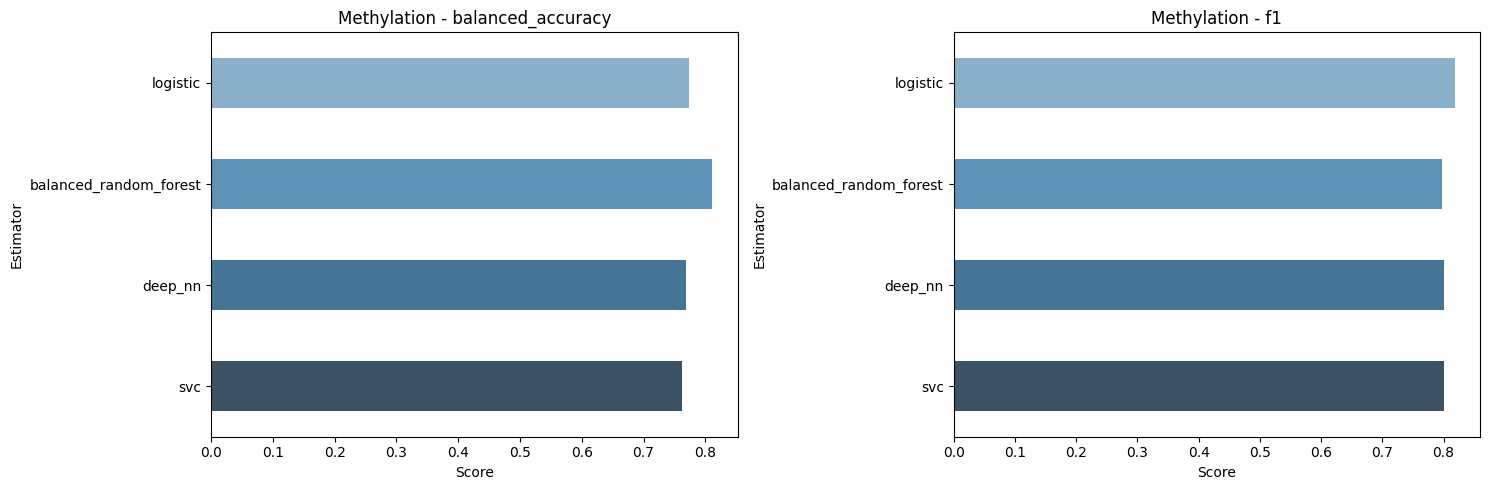

In [ ]:
plot_bar_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


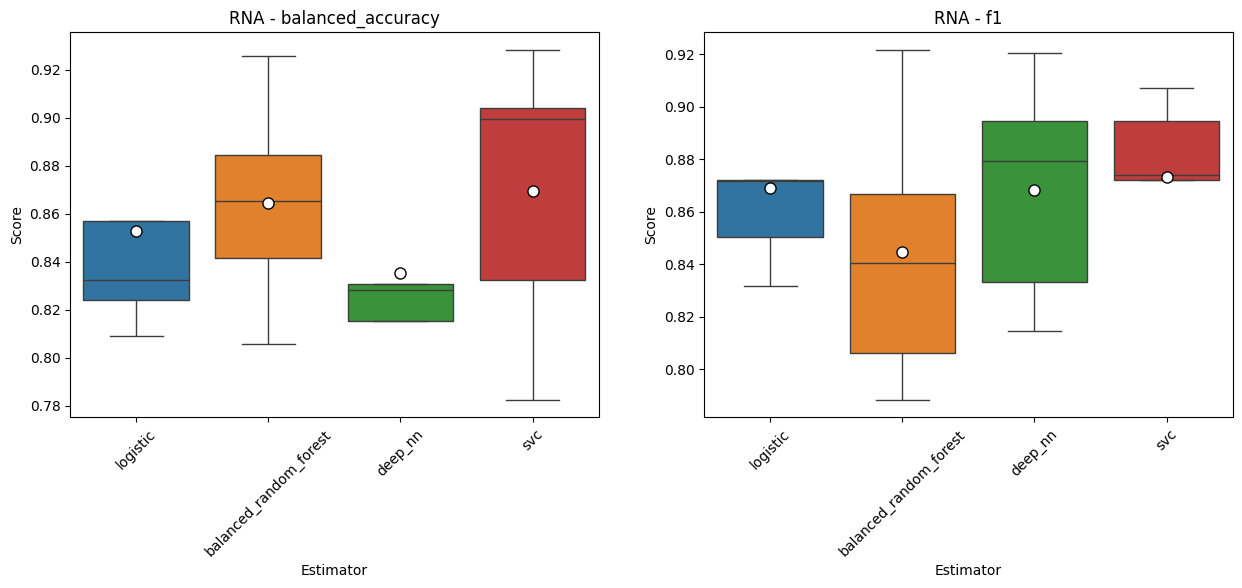

In [ ]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


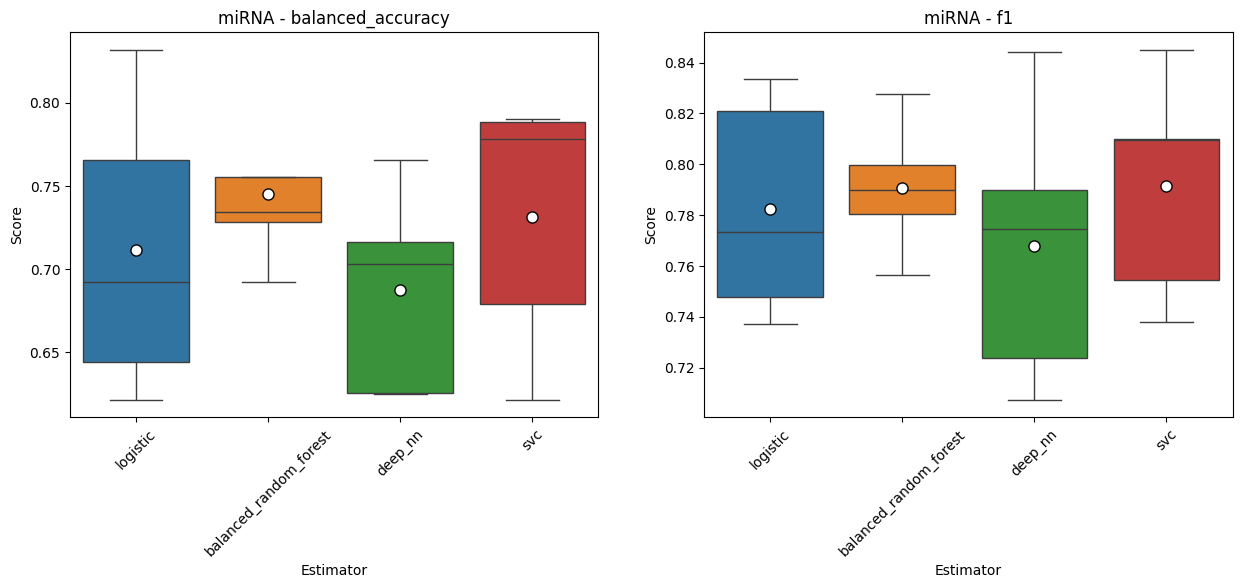

In [ ]:
plot_box_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


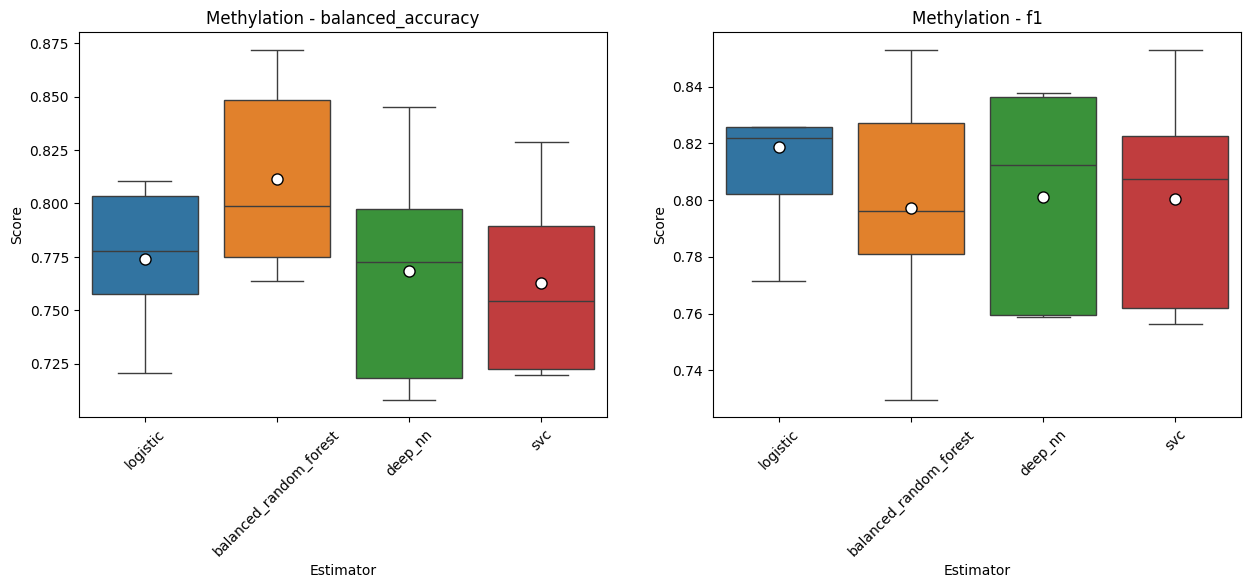

In [ ]:
plot_box_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

In [21]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring=brca_scoring, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1))

 25%|██▌       | 1/4 [00:17<00:52, 17.37s/it]

logistic                  accuracy balanced_accuracy               f1   recall (Basal)  \
logistic  0.873 +/- 0.037   0.846 +/- 0.060  0.871 +/- 0.039  0.972 +/- 0.043   

            recall (Her2)    recall (LumA)    recall (LumB)  
logistic  0.767 +/- 0.200  0.920 +/- 0.045  0.727 +/- 0.108  


 50%|█████     | 2/4 [00:32<00:31, 15.90s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.846 +/- 0.038   0.865 +/- 0.054  0.850 +/- 0.035   

                         recall (Basal)    recall (Her2)    recall (LumA)  \
balanced_random_forest  0.967 +/- 0.057  0.844 +/- 0.166  0.812 +/- 0.059   

                          recall (LumB)  
balanced_random_forest  0.837 +/- 0.056  


 75%|███████▌  | 3/4 [00:47<00:15, 15.66s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (Basal)  \
deep_nn  0.866 +/- 0.040   0.829 +/- 0.055  0.864 +/- 0.041  0.972 +/- 0.043   

           recall (Her2)    recall (LumA)    recall (LumB)  
deep_nn  0.689 +/- 0.171  0.908 +/- 0.045  0.747 +/- 0.112  


100%|██████████| 4/4 [00:50<00:00, 12.57s/it]


svc             accuracy balanced_accuracy               f1   recall (Basal)  \
svc  0.868 +/- 0.035   0.857 +/- 0.040  0.867 +/- 0.036  0.972 +/- 0.043   

       recall (Her2)    recall (LumA)    recall (LumB)  
svc  0.822 +/- 0.129  0.901 +/- 0.050  0.733 +/- 0.103  


 25%|██▌       | 1/4 [00:05<00:17,  5.83s/it]

logistic                  accuracy balanced_accuracy               f1   recall (Basal)  \
logistic  0.793 +/- 0.033   0.704 +/- 0.061  0.785 +/- 0.035  0.910 +/- 0.084   

            recall (Her2)    recall (LumA)    recall (LumB)  
logistic  0.422 +/- 0.171  0.894 +/- 0.046  0.590 +/- 0.111  


 50%|█████     | 2/4 [00:15<00:16,  8.31s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.779 +/- 0.034   0.728 +/- 0.046  0.779 +/- 0.032   

                         recall (Basal)    recall (Her2)    recall (LumA)  \
balanced_random_forest  0.939 +/- 0.086  0.511 +/- 0.187  0.827 +/- 0.054   

                          recall (LumB)  
balanced_random_forest  0.637 +/- 0.087  


 75%|███████▌  | 3/4 [00:23<00:07,  7.91s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (Basal)  \
deep_nn  0.795 +/- 0.033   0.690 +/- 0.050  0.782 +/- 0.035  0.920 +/- 0.051   

           recall (Her2)    recall (LumA)    recall (LumB)  
deep_nn  0.356 +/- 0.181  0.910 +/- 0.058  0.573 +/- 0.068  


100%|██████████| 4/4 [00:24<00:00,  6.13s/it]


svc             accuracy balanced_accuracy               f1   recall (Basal)  \
svc  0.805 +/- 0.041   0.733 +/- 0.066  0.800 +/- 0.041  0.943 +/- 0.065   

       recall (Her2)    recall (LumA)    recall (LumB)  
svc  0.489 +/- 0.197  0.888 +/- 0.045  0.613 +/- 0.094  


 25%|██▌       | 1/4 [00:10<00:30, 10.22s/it]

logistic                  accuracy balanced_accuracy               f1   recall (Basal)  \
logistic  0.811 +/- 0.030   0.775 +/- 0.062  0.805 +/- 0.034  0.957 +/- 0.051   

            recall (Her2)    recall (LumA)    recall (LumB)  
logistic  0.667 +/- 0.243  0.876 +/- 0.050  0.600 +/- 0.125  


 50%|█████     | 2/4 [00:17<00:16,  8.34s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.784 +/- 0.034   0.797 +/- 0.053  0.785 +/- 0.033   

                         recall (Basal)    recall (Her2)    recall (LumA)  \
balanced_random_forest  0.972 +/- 0.043  0.800 +/- 0.163  0.796 +/- 0.068   

                          recall (LumB)  
balanced_random_forest  0.620 +/- 0.103  


 75%|███████▌  | 3/4 [00:29<00:09,  9.95s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (Basal)  \
deep_nn  0.802 +/- 0.027   0.767 +/- 0.054  0.797 +/- 0.032  0.943 +/- 0.059   

           recall (Her2)    recall (LumA)    recall (LumB)  
deep_nn  0.667 +/- 0.202  0.870 +/- 0.047  0.587 +/- 0.137  


100%|██████████| 4/4 [00:30<00:00,  7.58s/it]

svc             accuracy balanced_accuracy               f1   recall (Basal)  \
svc  0.808 +/- 0.033   0.781 +/- 0.058  0.803 +/- 0.036  0.962 +/- 0.051   

       recall (Her2)    recall (LumA)    recall (LumB)  
svc  0.700 +/- 0.221  0.867 +/- 0.051  0.593 +/- 0.117  


In [22]:
display(base_metrics_df['rna']), display(base_metrics_df['mirna']), display(base_metrics_df['methylation'])

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.873 +/- 0.037,0.846 +/- 0.060,0.871 +/- 0.039,0.972 +/- 0.043,0.767 +/- 0.200,0.920 +/- 0.045,0.727 +/- 0.108
balanced_random_forest,0.846 +/- 0.038,0.865 +/- 0.054,0.850 +/- 0.035,0.967 +/- 0.057,0.844 +/- 0.166,0.812 +/- 0.059,0.837 +/- 0.056
deep_nn,0.866 +/- 0.040,0.829 +/- 0.055,0.864 +/- 0.041,0.972 +/- 0.043,0.689 +/- 0.171,0.908 +/- 0.045,0.747 +/- 0.112
svc,0.868 +/- 0.035,0.857 +/- 0.040,0.867 +/- 0.036,0.972 +/- 0.043,0.822 +/- 0.129,0.901 +/- 0.050,0.733 +/- 0.103


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.793 +/- 0.033,0.704 +/- 0.061,0.785 +/- 0.035,0.910 +/- 0.084,0.422 +/- 0.171,0.894 +/- 0.046,0.590 +/- 0.111
balanced_random_forest,0.779 +/- 0.034,0.728 +/- 0.046,0.779 +/- 0.032,0.939 +/- 0.086,0.511 +/- 0.187,0.827 +/- 0.054,0.637 +/- 0.087
deep_nn,0.795 +/- 0.033,0.690 +/- 0.050,0.782 +/- 0.035,0.920 +/- 0.051,0.356 +/- 0.181,0.910 +/- 0.058,0.573 +/- 0.068
svc,0.805 +/- 0.041,0.733 +/- 0.066,0.800 +/- 0.041,0.943 +/- 0.065,0.489 +/- 0.197,0.888 +/- 0.045,0.613 +/- 0.094


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.811 +/- 0.030,0.775 +/- 0.062,0.805 +/- 0.034,0.957 +/- 0.051,0.667 +/- 0.243,0.876 +/- 0.050,0.600 +/- 0.125
balanced_random_forest,0.784 +/- 0.034,0.797 +/- 0.053,0.785 +/- 0.033,0.972 +/- 0.043,0.800 +/- 0.163,0.796 +/- 0.068,0.620 +/- 0.103
deep_nn,0.802 +/- 0.027,0.767 +/- 0.054,0.797 +/- 0.032,0.943 +/- 0.059,0.667 +/- 0.202,0.870 +/- 0.047,0.587 +/- 0.137
svc,0.808 +/- 0.033,0.781 +/- 0.058,0.803 +/- 0.036,0.962 +/- 0.051,0.700 +/- 0.221,0.867 +/- 0.051,0.593 +/- 0.117


(None, None, None)

## Modality Ensembles

In [23]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [ ]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring=brca_scoring)
    modality_metrics = pd.concat([modality_metrics, df])

100%|██████████| 3/3 [02:14<00:00, 44.86s/it]


In [24]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring=brca_scoring, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1))
    modality_metrics = pd.concat([modality_metrics, df])

100%|██████████| 3/3 [04:31<00:00, 90.65s/it]


### Scoring

In [ ]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.863 +/- 0.015,0.860 +/- 0.038,0.861 +/- 0.019,0.972 +/- 0.034,0.867 +/- 0.163,0.900 +/- 0.018,0.700 +/- 0.100
mirna,0.795 +/- 0.045,0.731 +/- 0.087,0.786 +/- 0.049,0.916 +/- 0.052,0.567 +/- 0.291,0.900 +/- 0.059,0.540 +/- 0.120
methylation,0.812 +/- 0.033,0.768 +/- 0.045,0.807 +/- 0.037,0.945 +/- 0.050,0.633 +/- 0.125,0.882 +/- 0.049,0.610 +/- 0.146


In [ ]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.912 +/- 0.034,0.891 +/- 0.057,0.910 +/- 0.036,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.810 +/- 0.120
mirna,0.821 +/- 0.022,0.779 +/- 0.041,0.814 +/- 0.026,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.590 +/- 0.150
methylation,0.833 +/- 0.053,0.807 +/- 0.063,0.830 +/- 0.057,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.032,0.650 +/- 0.161


In [25]:
# 5x3
modality_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.880 +/- 0.034,0.862 +/- 0.034,0.878 +/- 0.033,0.972 +/- 0.043,0.822 +/- 0.142,0.925 +/- 0.052,0.727 +/- 0.087
mirna,0.818 +/- 0.031,0.748 +/- 0.041,0.811 +/- 0.030,0.943 +/- 0.053,0.544 +/- 0.129,0.912 +/- 0.048,0.593 +/- 0.095
methylation,0.809 +/- 0.034,0.770 +/- 0.060,0.803 +/- 0.041,0.962 +/- 0.051,0.656 +/- 0.197,0.881 +/- 0.040,0.583 +/- 0.141


In [26]:
import json

In [ ]:
# Convert and write JSON object to file
with open("results/brca/brca_modality_results.json", "w") as outfile:
    json.dump(scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [27]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]

all_scores = {}

for modality in base_scores:
    all_scores[modality] = {}
    for i in range(len(base_scores[modality])):
        all_scores[modality][estimator_names[i]] = base_scores[modality][i]

    all_scores[modality]['stacking'] = scores[modality]

In [ ]:
# Convert and write JSON object to file
with open("results/brca/brca_base_learner_modality_results.json", "w") as outfile:
    json.dump(all_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [ ]:
# Run this if continuing an already saved run:
with open("results/brca/brca_modality_results.json",'r+') as file:
    modality_scores = json.load(file)
    modality_metrics = pd.DataFrame()

    for model in modality_scores:
      metrics = {}

      for scorer in brca_scoring:
        metrics[scorer] = []

      for scorer in brca_scoring:
          metrics[scorer].append(
              "%0.3f +/- %0.3f"
              % (np.mean(modality_scores[model]["test_%s" % scorer]), np.std(modality_scores[model]["test_%s" % scorer]))
      )
      modality_metrics = pd.concat([modality_metrics, pd.DataFrame(metrics, index=[model])])

In [28]:
all_metrics = {}

# Joining metrics together for visualization
for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [ ]:
# Balanced random forest and standard scaler with deep neural network
display(all_metrics['rna'], all_metrics['mirna'], all_metrics['methylation'])

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.870 +/- 0.028,0.853 +/- 0.047,0.869 +/- 0.029,0.972 +/- 0.034,0.800 +/- 0.125,0.908 +/- 0.009,0.730 +/- 0.098
balanced_random_forest,0.840 +/- 0.048,0.865 +/- 0.040,0.845 +/- 0.047,0.958 +/- 0.057,0.867 +/- 0.067,0.803 +/- 0.042,0.830 +/- 0.117
deep_nn,0.870 +/- 0.038,0.835 +/- 0.041,0.868 +/- 0.039,0.972 +/- 0.034,0.700 +/- 0.125,0.908 +/- 0.036,0.760 +/- 0.116
svc,0.874 +/- 0.028,0.869 +/- 0.054,0.873 +/- 0.030,0.972 +/- 0.034,0.867 +/- 0.163,0.908 +/- 0.021,0.730 +/- 0.093
rna,0.863 +/- 0.015,0.860 +/- 0.038,0.861 +/- 0.019,0.972 +/- 0.034,0.867 +/- 0.163,0.900 +/- 0.018,0.700 +/- 0.100


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.791 +/- 0.034,0.711 +/- 0.078,0.783 +/- 0.038,0.902 +/- 0.056,0.467 +/- 0.306,0.887 +/- 0.042,0.590 +/- 0.097
balanced_random_forest,0.795 +/- 0.024,0.745 +/- 0.040,0.791 +/- 0.023,0.945 +/- 0.050,0.533 +/- 0.287,0.843 +/- 0.029,0.660 +/- 0.166
deep_nn,0.781 +/- 0.045,0.687 +/- 0.055,0.768 +/- 0.049,0.930 +/- 0.045,0.400 +/- 0.133,0.900 +/- 0.059,0.520 +/- 0.103
svc,0.798 +/- 0.036,0.732 +/- 0.069,0.791 +/- 0.039,0.916 +/- 0.052,0.533 +/- 0.267,0.887 +/- 0.042,0.590 +/- 0.073
mirna,0.795 +/- 0.045,0.731 +/- 0.087,0.786 +/- 0.049,0.916 +/- 0.052,0.567 +/- 0.291,0.900 +/- 0.059,0.540 +/- 0.120


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.821 +/- 0.033,0.774 +/- 0.033,0.819 +/- 0.033,0.958 +/- 0.034,0.600 +/- 0.082,0.878 +/- 0.047,0.660 +/- 0.116
balanced_random_forest,0.791 +/- 0.042,0.812 +/- 0.042,0.797 +/- 0.042,0.958 +/- 0.034,0.800 +/- 0.067,0.768 +/- 0.043,0.720 +/- 0.093
deep_nn,0.807 +/- 0.031,0.768 +/- 0.051,0.801 +/- 0.035,0.945 +/- 0.050,0.667 +/- 0.149,0.882 +/- 0.058,0.580 +/- 0.147
svc,0.805 +/- 0.033,0.763 +/- 0.041,0.800 +/- 0.037,0.945 +/- 0.050,0.633 +/- 0.067,0.874 +/- 0.065,0.600 +/- 0.152
methylation,0.812 +/- 0.033,0.768 +/- 0.045,0.807 +/- 0.037,0.945 +/- 0.050,0.633 +/- 0.125,0.882 +/- 0.049,0.610 +/- 0.146


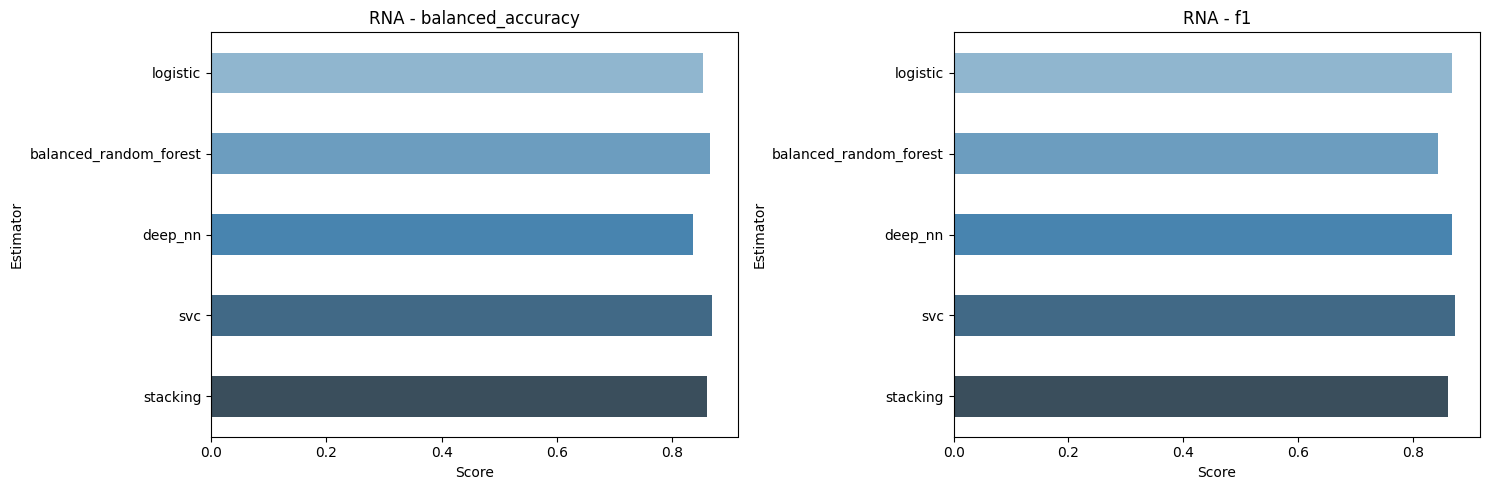

In [ ]:
plot_bar_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

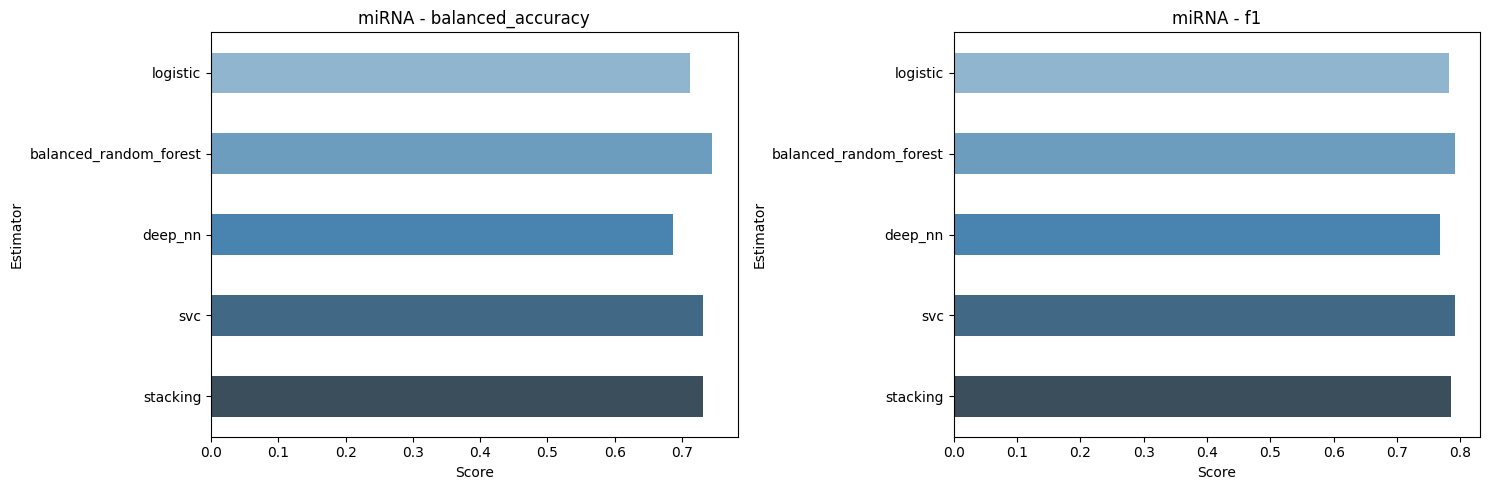

In [ ]:
plot_bar_scores(estimator_names, all_scores['mirna'].values(), 'miRNA', metrics=['balanced_accuracy', 'f1'])

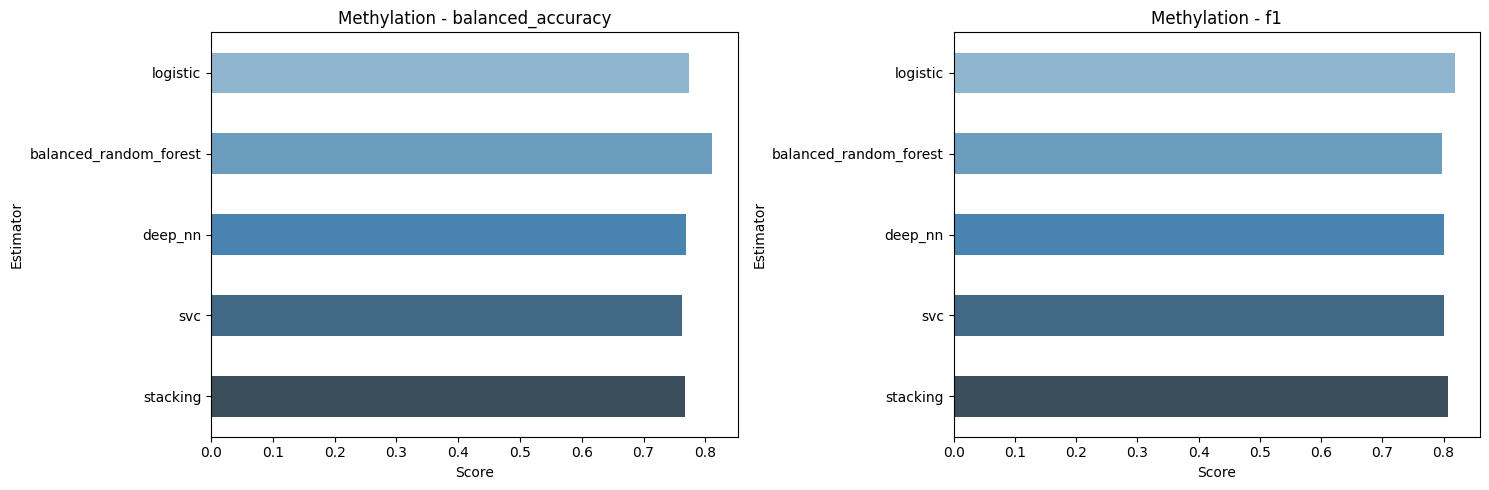

In [ ]:
plot_bar_scores(estimator_names, all_scores['methylation'].values(), 'Methylation', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


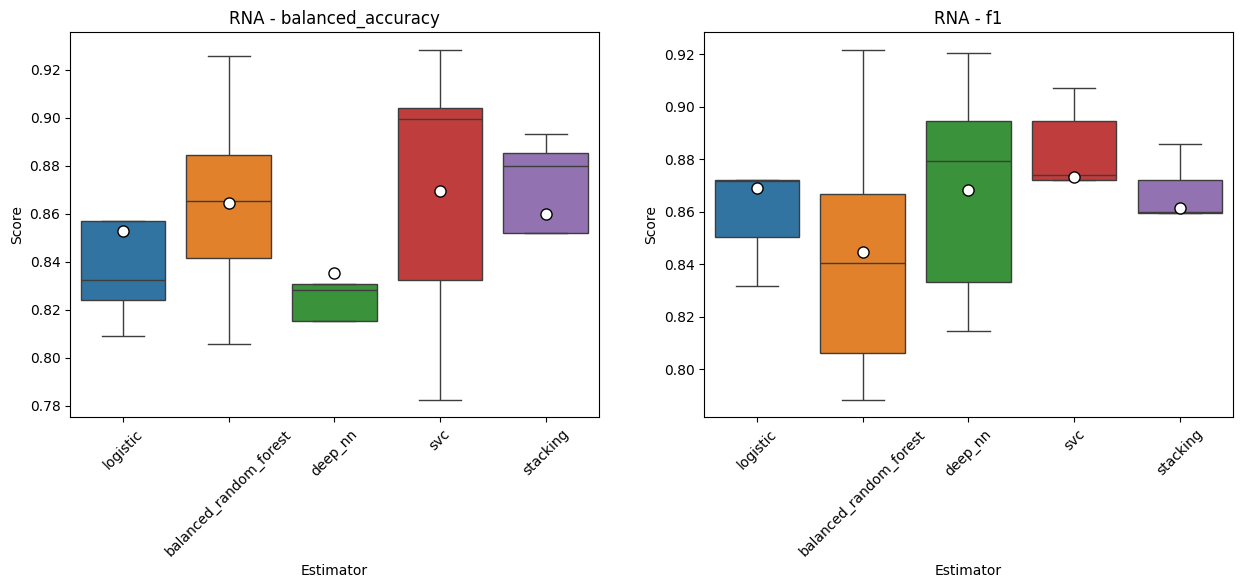

In [ ]:
plot_box_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


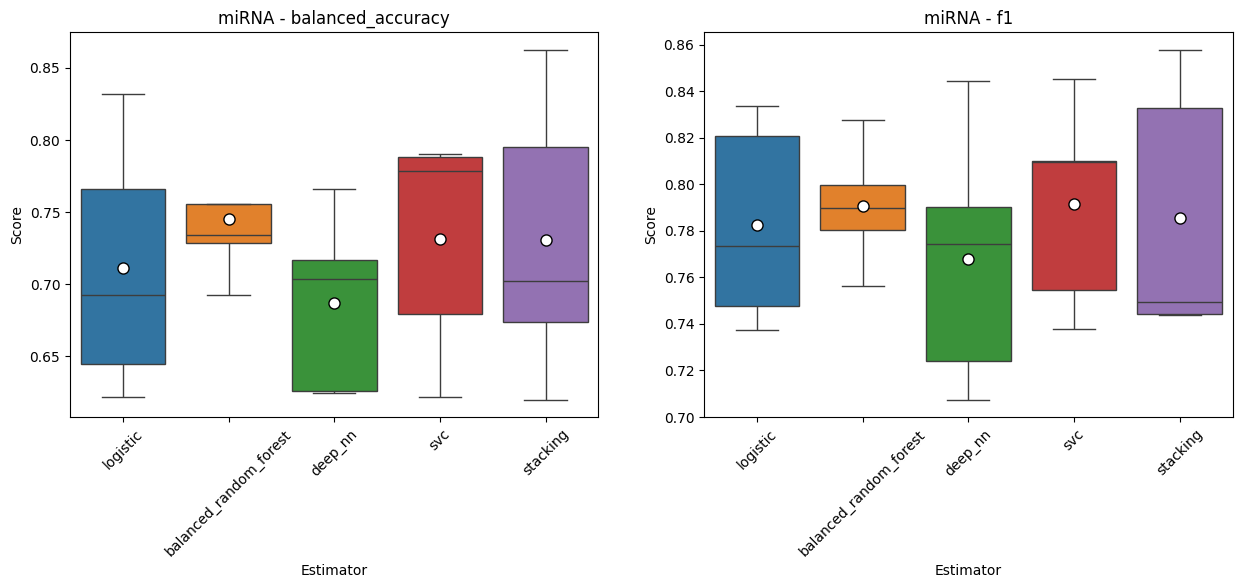

In [ ]:
plot_box_scores(estimator_names, all_scores['mirna'].values(), 'miRNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


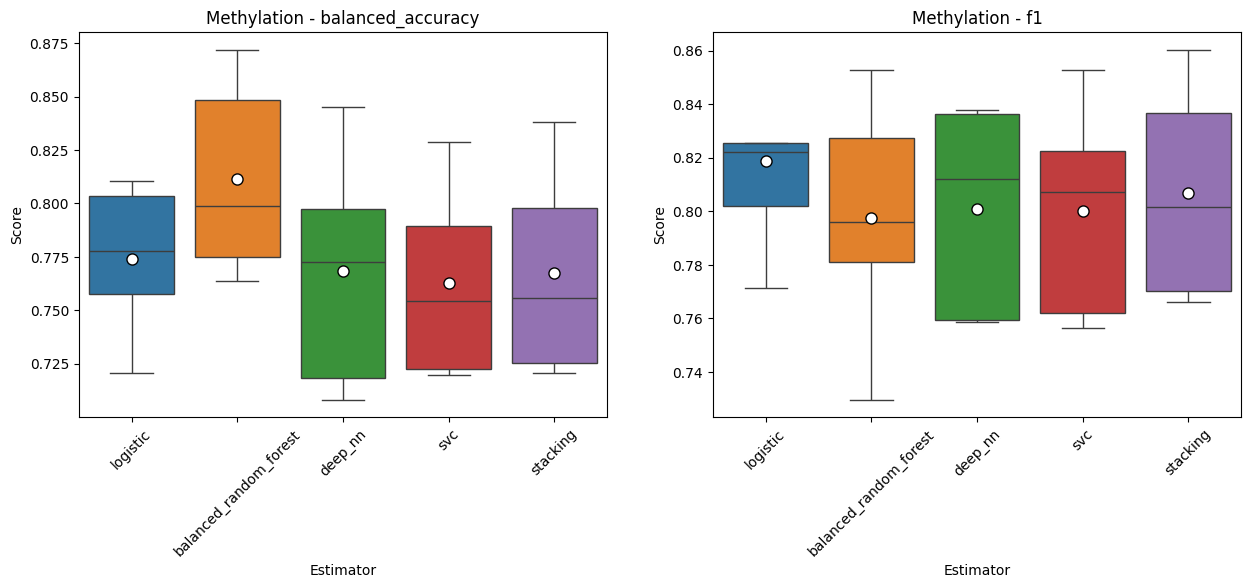

In [ ]:
plot_box_scores(estimator_names, all_scores['methylation'].values(), 'Methylation', metrics=['balanced_accuracy', 'f1'])

In [29]:
# Balanced random forest and standard scaler with deep neural network
display(all_metrics['rna'], all_metrics['mirna'], all_metrics['methylation'])

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.873 +/- 0.037,0.846 +/- 0.060,0.871 +/- 0.039,0.972 +/- 0.043,0.767 +/- 0.200,0.920 +/- 0.045,0.727 +/- 0.108
balanced_random_forest,0.846 +/- 0.038,0.865 +/- 0.054,0.850 +/- 0.035,0.967 +/- 0.057,0.844 +/- 0.166,0.812 +/- 0.059,0.837 +/- 0.056
deep_nn,0.866 +/- 0.040,0.829 +/- 0.055,0.864 +/- 0.041,0.972 +/- 0.043,0.689 +/- 0.171,0.908 +/- 0.045,0.747 +/- 0.112
svc,0.868 +/- 0.035,0.857 +/- 0.040,0.867 +/- 0.036,0.972 +/- 0.043,0.822 +/- 0.129,0.901 +/- 0.050,0.733 +/- 0.103
rna,0.880 +/- 0.034,0.862 +/- 0.034,0.878 +/- 0.033,0.972 +/- 0.043,0.822 +/- 0.142,0.925 +/- 0.052,0.727 +/- 0.087


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.793 +/- 0.033,0.704 +/- 0.061,0.785 +/- 0.035,0.910 +/- 0.084,0.422 +/- 0.171,0.894 +/- 0.046,0.590 +/- 0.111
balanced_random_forest,0.779 +/- 0.034,0.728 +/- 0.046,0.779 +/- 0.032,0.939 +/- 0.086,0.511 +/- 0.187,0.827 +/- 0.054,0.637 +/- 0.087
deep_nn,0.795 +/- 0.033,0.690 +/- 0.050,0.782 +/- 0.035,0.920 +/- 0.051,0.356 +/- 0.181,0.910 +/- 0.058,0.573 +/- 0.068
svc,0.805 +/- 0.041,0.733 +/- 0.066,0.800 +/- 0.041,0.943 +/- 0.065,0.489 +/- 0.197,0.888 +/- 0.045,0.613 +/- 0.094
mirna,0.818 +/- 0.031,0.748 +/- 0.041,0.811 +/- 0.030,0.943 +/- 0.053,0.544 +/- 0.129,0.912 +/- 0.048,0.593 +/- 0.095


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.811 +/- 0.030,0.775 +/- 0.062,0.805 +/- 0.034,0.957 +/- 0.051,0.667 +/- 0.243,0.876 +/- 0.050,0.600 +/- 0.125
balanced_random_forest,0.784 +/- 0.034,0.797 +/- 0.053,0.785 +/- 0.033,0.972 +/- 0.043,0.800 +/- 0.163,0.796 +/- 0.068,0.620 +/- 0.103
deep_nn,0.802 +/- 0.027,0.767 +/- 0.054,0.797 +/- 0.032,0.943 +/- 0.059,0.667 +/- 0.202,0.870 +/- 0.047,0.587 +/- 0.137
svc,0.808 +/- 0.033,0.781 +/- 0.058,0.803 +/- 0.036,0.962 +/- 0.051,0.700 +/- 0.221,0.867 +/- 0.051,0.593 +/- 0.117
methylation,0.809 +/- 0.034,0.770 +/- 0.060,0.803 +/- 0.041,0.962 +/- 0.051,0.656 +/- 0.197,0.881 +/- 0.040,0.583 +/- 0.141


In [35]:
# Picking models we want to compare performances for
compare = [
    ('rna', 'stacking', 'logistic'),
    ('mirna', 'stacking', 'svc'),
    ('methylation', 'logistic', 'stacking')
]

In [36]:
from scipy.stats import wilcoxon

wilcoxen_results = {}
metrics = ['balanced_accuracy', 'f1']

for metric in metrics:
    wilcoxen_results[metric] = pd.DataFrame()
    for modality, est1, est2 in compare:
        df = wilcoxen_test(est1, est2, all_scores[modality][est1]['test_' + metric], all_scores[modality][est2]['test_' + metric])
        wilcoxen_results[metric] = pd.concat([wilcoxen_results[metric], df])


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if ther

In [37]:
display(wilcoxen_results['balanced_accuracy'], wilcoxen_results['f1'])

,estimator_1,estimator_2,statistic,p,significant
0,stacking,logistic,77.0,0.179565,False
0,stacking,svc,74.0,0.088557,False
0,logistic,stacking,37.0,0.16644,False


,estimator_1,estimator_2,statistic,p,significant
0,stacking,logistic,78.0,0.165131,False
0,stacking,svc,81.0,0.036797,True
0,logistic,stacking,45.0,0.318935,False


## Multi Omics Integration Ensemble

### Ensemble Model as a Custom Classifier

In [22]:
column_names = {}

for key in X.keys():
    column_names[key] = X[key].columns

In [23]:
meta_ensembles = {}
meta_ensembles['rna + mirna + meth'] = MultiOmicsIntegrationClassifier(classifiers, cv=3)
meta_ensembles['mirna + meth'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['mirna', 'methylation']}, cv=3)
meta_ensembles['rna + mirna'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'mirna']}, cv=3)
meta_ensembles['rna + meth'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'methylation']}, cv=3)

In [24]:
X_merged = {}
X_merged['rna + mirna + meth'] = pd.concat([X['rna'], X['mirna'], X['methylation']], axis=1, join='inner')
X_merged['mirna + meth'] = pd.concat([X['mirna'], X['methylation']], axis=1, join='inner')
X_merged['rna + mirna'] = pd.concat([X['rna'], X['mirna']], axis=1, join='inner')
X_merged['rna + meth'] = pd.concat([X['rna'], X['methylation']], axis=1, join='inner')


In [ ]:
integration_scores = {}
integration_metrics = {}

In [ ]:
integration_scores['rna + mirna + meth'], integration_metrics['rna + mirna + meth'] = get_cross_metrics(meta_ensembles['rna + mirna + meth'], X_merged['rna + mirna + meth'], y, name='rna + mirna + meth', cv=5, scoring=brca_scoring, fit_params={'column_names': column_names})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


In [ ]:
integration_metrics['rna + mirna + meth']

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna + mirna + meth,0.874 +/- 0.020,0.859 +/- 0.037,0.873 +/- 0.023,0.972 +/- 0.034,0.833 +/- 0.105,0.921 +/- 0.022,0.710 +/- 0.102


In [ ]:
integration_scores['mirna + meth'], integration_metrics['mirna + meth'] = get_cross_metrics(meta_ensembles['mirna + meth'], X_merged['mirna + meth'], y, name='mirna + meth', cv=5, verbose=2, scoring=brca_scoring, fit_params={'column_names': {key: column_names[key] for key in ['mirna', 'methylation']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished


In [ ]:
integration_scores['rna + mirna'], integration_metrics['rna + mirna'] = get_cross_metrics(meta_ensembles['rna + mirna'], X_merged['rna + mirna'], y, name='rna + mirna', cv=5, verbose=2, scoring=brca_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'mirna']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


In [ ]:
integration_scores['rna + meth'], integration_metrics['rna + meth'] = get_cross_metrics(meta_ensembles['rna + meth'], X_merged['rna + meth'], y, name='rna + meth', cv=5, verbose=2, scoring=brca_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'methylation']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


In [ ]:
all_integration_metrics = pd.concat([modality_metrics, pd.concat([x for x in integration_metrics.values()])])
names = ['rna', 'mirna', 'meth', 'rna + mirna + meth', 'mirna + meth', 'rna + mirna', 'rna + meth']

all_integration_scores = scores

# Adding multi-omic ensemble scores
for name, value in integration_scores.items():
    all_integration_scores[name] = value

In [ ]:
all_integration_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.863 +/- 0.015,0.860 +/- 0.038,0.861 +/- 0.019,0.972 +/- 0.034,0.867 +/- 0.163,0.900 +/- 0.018,0.700 +/- 0.100
mirna,0.795 +/- 0.045,0.731 +/- 0.087,0.786 +/- 0.049,0.916 +/- 0.052,0.567 +/- 0.291,0.900 +/- 0.059,0.540 +/- 0.120
methylation,0.812 +/- 0.033,0.768 +/- 0.045,0.807 +/- 0.037,0.945 +/- 0.050,0.633 +/- 0.125,0.882 +/- 0.049,0.610 +/- 0.146
rna + mirna + meth,0.874 +/- 0.020,0.859 +/- 0.037,0.873 +/- 0.023,0.972 +/- 0.034,0.833 +/- 0.105,0.921 +/- 0.022,0.710 +/- 0.102
mirna + meth,0.837 +/- 0.016,0.778 +/- 0.037,0.829 +/- 0.024,0.972 +/- 0.034,0.600 +/- 0.133,0.921 +/- 0.047,0.620 +/- 0.157
rna + mirna,0.884 +/- 0.007,0.866 +/- 0.025,0.882 +/- 0.009,0.972 +/- 0.034,0.833 +/- 0.149,0.930 +/- 0.026,0.730 +/- 0.075
rna + meth,0.881 +/- 0.023,0.874 +/- 0.045,0.880 +/- 0.025,0.972 +/- 0.034,0.867 +/- 0.163,0.917 +/- 0.009,0.740 +/- 0.097


In [ ]:
# Convert and write JSON object to file
with open("results/brca/brca_multi_omics_results.json", "w") as outfile:
    json.dump(integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [ ]:
# Convert and write JSON object to file
with open("results/brca/brca_modality_multi_omics_results.json", "w") as outfile:
    json.dump(all_integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

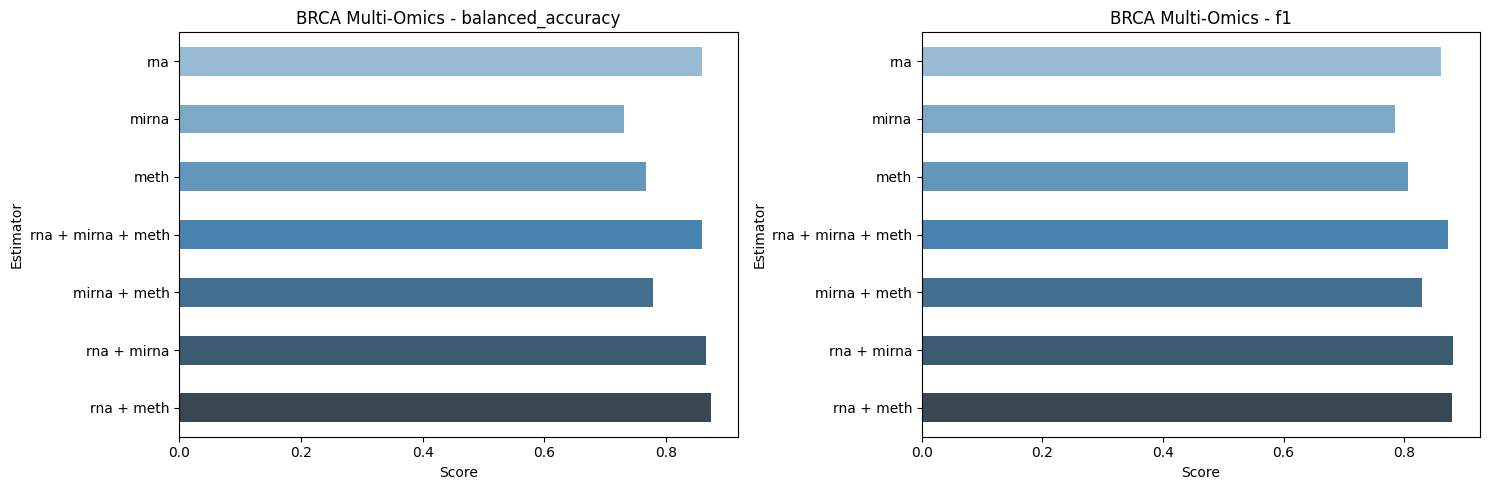

In [ ]:
plot_bar_scores(names, all_integration_scores.values(), 'BRCA Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


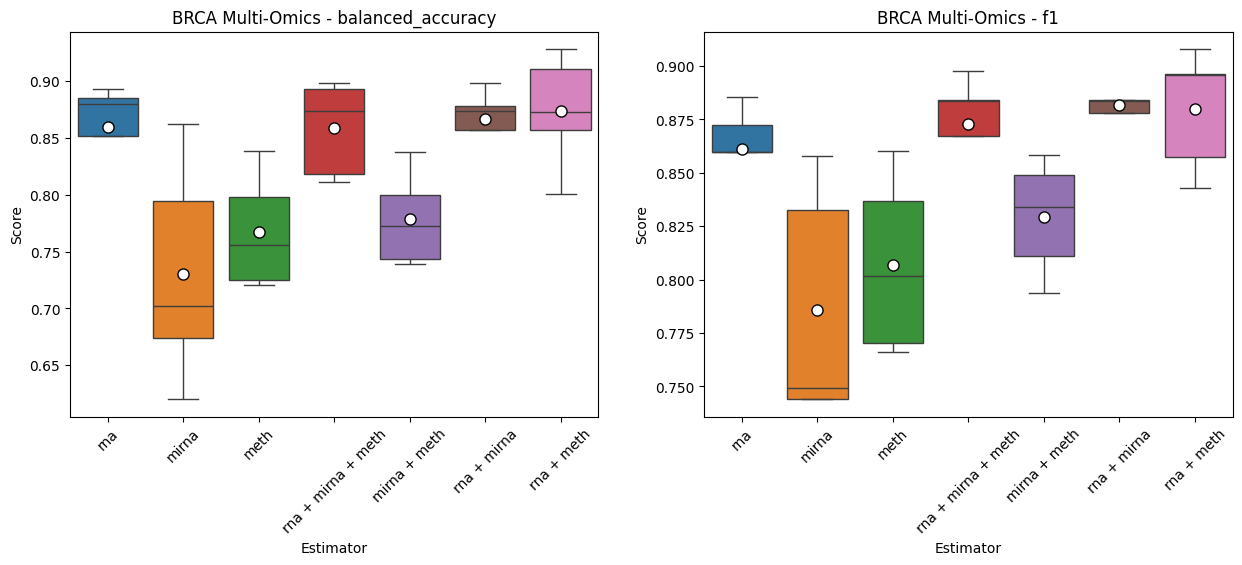

In [ ]:
plot_box_scores(names, all_integration_scores.values(), 'BRCA Multi-Omics', metrics=['balanced_accuracy', 'f1'])

## Statistical Significance

Now that we see the results, we want to check if the performance differences between our multi-omics ensemble models and the modality ensemble models are significant. We can employ the Wilcoxen test, using multiple replications of cross-validation to get scores.

### Wilcoxen

In [25]:
ensemble_results = {}
ensemble_metrics = {}

In [ ]:
def wilcoxen_test(name_1, name_2, scores_1, scores_2):

    stat, p = wilcoxon(scores_1, scores_2, alternative='greater')

    df = pd.Series({'estimator_1': name_1, 'estimator_2': name_2, 'statistic': stat, 'p': p, 'significant': p <= 0.05})

    return pd.DataFrame(df).T

In [ ]:
ensemble_results['rna'], ensemble_metrics['rna'] = get_cross_metrics(classifiers['rna'], X['rna'], y, name='rna', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=brca_scoring)

In [26]:
ensemble_results['mirna'], ensemble_metrics['mirna'] = get_cross_metrics(classifiers['mirna'], X['mirna'], y, name='mirna', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=brca_scoring)

In [ ]:
ensemble_results['meth'], ensemble_metrics['meth'] = get_cross_metrics(classifiers['methylation'], X['methylation'], y, name='meth', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=brca_scoring)

In [ ]:
ensemble_results['rna + mirna'], ensemble_metrics['rna + mirna'] = get_cross_metrics(meta_ensembles['rna + mirna'], X_merged['rna + mirna'], y, name='rna + mirna', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=brca_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'mirna']}})

In [ ]:
ensemble_results['rna + meth'], ensemble_metrics['rna + meth'] = get_cross_metrics(meta_ensembles['rna + meth'], X_merged['rna + meth'], y, name='rna + meth', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=brca_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'methylation']}})

In [ ]:
ensemble_results['mirna + meth'], ensemble_metrics['mirna + meth'] = get_cross_metrics(meta_ensembles['mirna + meth'], X_merged['mirna + meth'], y, name='mirna + meth', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=brca_scoring, fit_params={'column_names': {key: column_names[key] for key in ['mirna', 'methylation']}})

In [ ]:
ensemble_results['rna + mirna + meth'], ensemble_metrics['rna + mirna + meth'] = get_cross_metrics(meta_ensembles['rna + mirna + meth'], X_merged['rna + mirna + meth'], y, name='rna + mirna + meth', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=brca_scoring, fit_params={'column_names': column_names})

In [ ]:
# Picking models we want to compare performances for
compare = [
    ('mirna + meth', 'meth'),
    ('rna + mirna + meth', 'rna'),
    ('rna + meth', 'rna'),
    ('rna + mirna', 'rna')
]

In [ ]:

wilcoxen_results = {}
metrics = ['balanced_accuracy', 'f1']

for metric in metrics:
    wilcoxen_results[metric] = pd.DataFrame()
    for est1, est2 in compare:
        df = wilcoxen_test(est1, est2, ensemble_results[est1]['test_' + metric], ensemble_results[est2]['test_' + metric])
        wilcoxen_results[metric] = pd.concat([wilcoxen_results[metric], df])


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if ther

In [ ]:
display(wilcoxen_results['balanced_accuracy'], wilcoxen_results['f1'])

,estimator_1,estimator_2,statistic,p,significant
0,mirna + meth,meth,90.0,0.047302,True
0,rna + mirna + meth,rna,34.5,0.779047,False
0,rna + meth,rna,19.5,0.792892,False
0,rna + mirna,rna,55.0,0.253113,False


,estimator_1,estimator_2,statistic,p,significant
0,mirna + meth,meth,118.0,0.000092,True
0,rna + mirna + meth,rna,52.0,0.324822,False
0,rna + meth,rna,31.0,0.734858,False
0,rna + mirna,rna,58.0,0.191176,False


/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


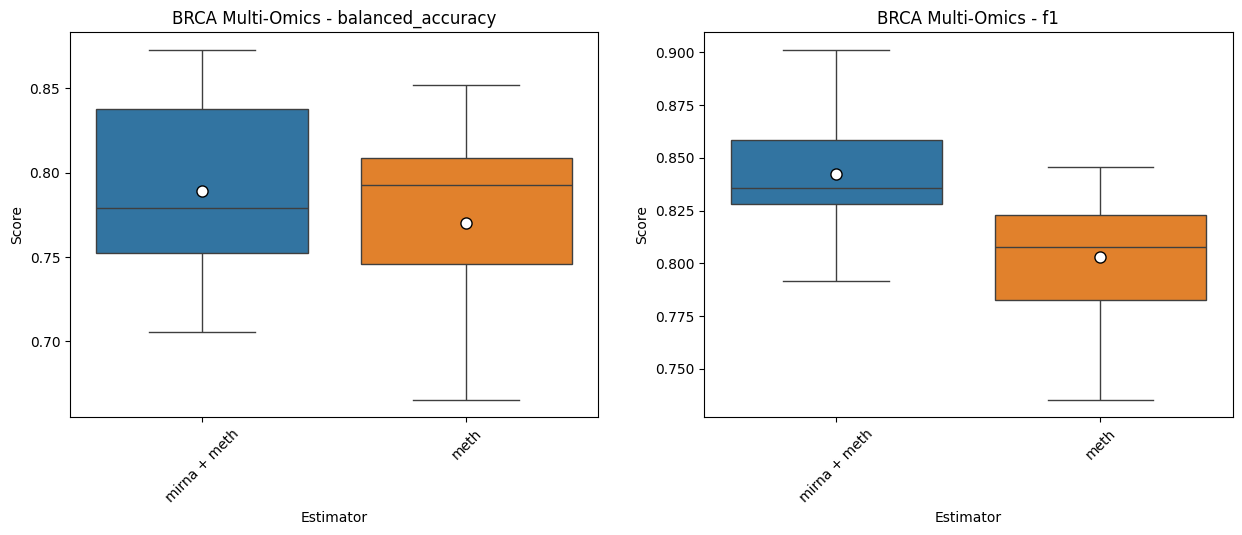

In [ ]:
plot_box_scores(['mirna + meth', 'meth'], [ensemble_results['mirna + meth'], ensemble_results['meth']], 'BRCA Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


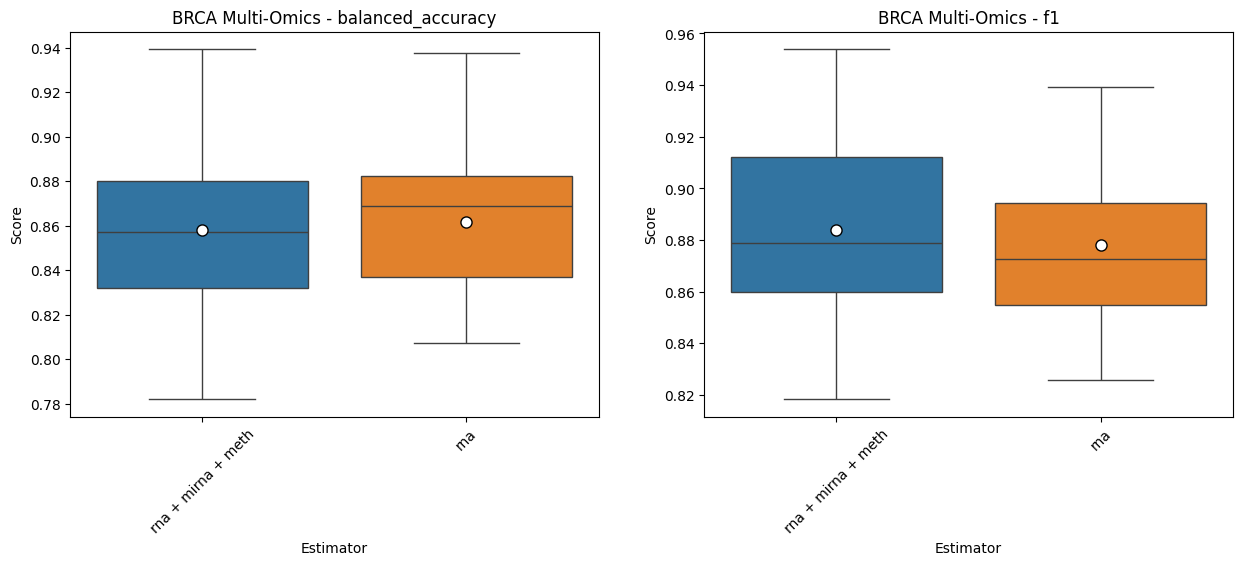

In [ ]:
plot_box_scores(['rna + mirna + meth', 'rna'], [ensemble_results['rna + mirna + meth'], ensemble_results['rna']], 'BRCA Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


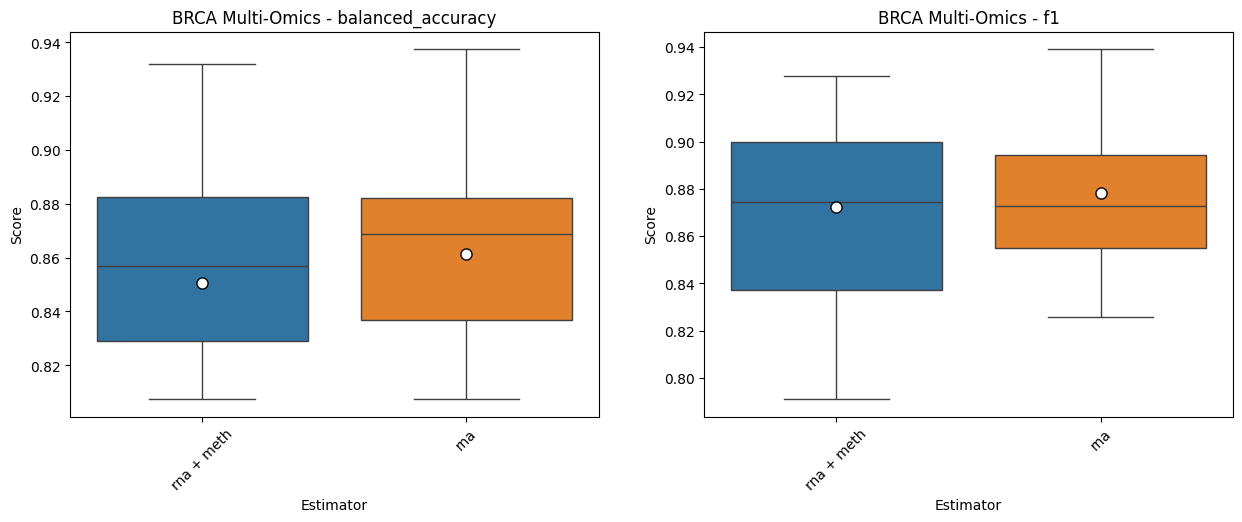

In [ ]:
plot_box_scores(['rna + meth', 'rna'], [ensemble_results['rna + meth'], ensemble_results['rna']], 'BRCA Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


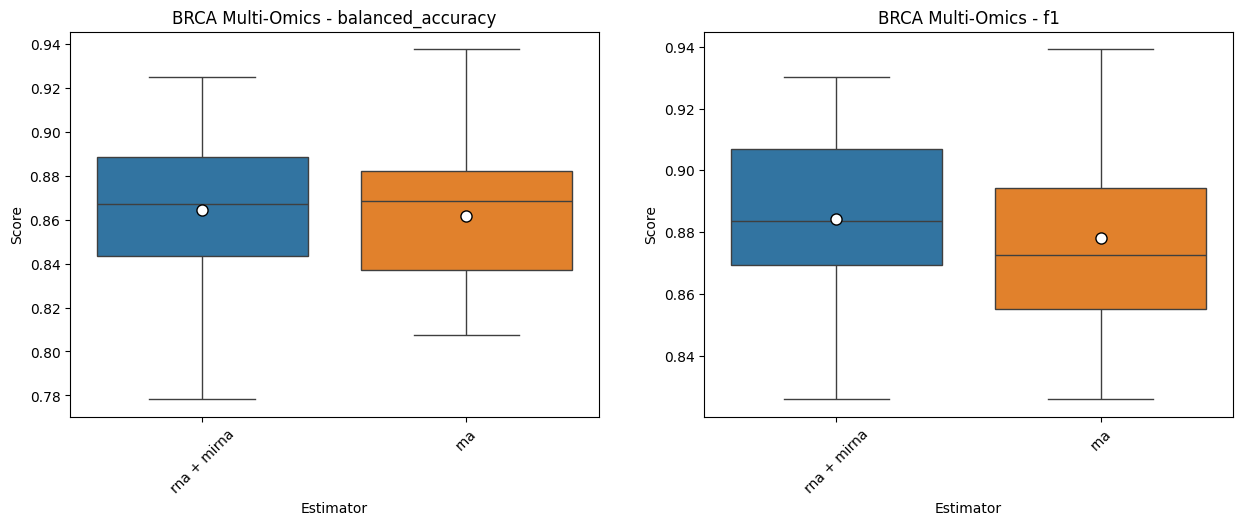

In [ ]:
plot_box_scores(['rna + mirna', 'rna'], [ensemble_results['rna + mirna'], ensemble_results['rna']], 'BRCA Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [28]:
import json

In [29]:
# Run this if continuing an already saved run:
with open("results/brca/brca_5x3_results.json",'r+') as file:
    ensemble_results_2 = json.load(file)
    ensemble_metrics_2 = pd.DataFrame()

    for model in ensemble_results_2:
      metrics = {}

      for scorer in brca_scoring:
        metrics[scorer] = []

      for scorer in brca_scoring:
          metrics[scorer].append(
              "%0.3f +/- %0.3f"
              % (np.mean(ensemble_results_2[model]["test_%s" % scorer]), np.std(ensemble_results_2[model]["test_%s" % scorer]))
      )
      ensemble_metrics_2 = pd.concat([ensemble_metrics_2, pd.DataFrame(metrics, index=[model])])

In [ ]:
ensemble_metrics_2

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
mirna + meth,0.847 +/- 0.030,0.789 +/- 0.050,0.842 +/- 0.031,0.972 +/- 0.043,0.600 +/- 0.191,0.921 +/- 0.044,0.663 +/- 0.090
meth,0.809 +/- 0.034,0.770 +/- 0.060,0.803 +/- 0.041,0.962 +/- 0.051,0.656 +/- 0.197,0.881 +/- 0.040,0.583 +/- 0.141
rna + mirna + meth,0.885 +/- 0.038,0.858 +/- 0.047,0.884 +/- 0.039,0.972 +/- 0.043,0.778 +/- 0.169,0.930 +/- 0.046,0.753 +/- 0.087
rna,0.880 +/- 0.034,0.862 +/- 0.034,0.878 +/- 0.033,0.972 +/- 0.043,0.822 +/- 0.142,0.925 +/- 0.052,0.727 +/- 0.087
rna + meth,0.875 +/- 0.038,0.851 +/- 0.055,0.872 +/- 0.040,0.972 +/- 0.043,0.789 +/- 0.187,0.925 +/- 0.046,0.717 +/- 0.111
rna + mirna,0.886 +/- 0.031,0.865 +/- 0.038,0.884 +/- 0.031,0.967 +/- 0.044,0.822 +/- 0.155,0.936 +/- 0.047,0.733 +/- 0.092


In [31]:
integration_results = {}
integration_results['rna'] = ensemble_results_2['rna']
integration_results['mirna'] = ensemble_results['mirna']
integration_results['meth'] = ensemble_results_2['meth']
integration_results['rna + mirna'] = ensemble_results_2['rna + mirna']
integration_results['rna + meth'] = ensemble_results_2['rna + meth']
integration_results['mirna + meth'] = ensemble_results_2['mirna + meth']
integration_results['rna + mirna + meth'] = ensemble_results_2['rna + mirna + meth']

In [32]:
integration_metrics = pd.DataFrame()

for model in integration_results:
      metrics = {}

      for scorer in brca_scoring:
        metrics[scorer] = []

      for scorer in brca_scoring:
          metrics[scorer].append(
              "%0.3f +/- %0.3f"
              % (np.mean(integration_results[model]["test_%s" % scorer]), np.std(integration_results[model]["test_%s" % scorer]))
      )
      integration_metrics = pd.concat([integration_metrics, pd.DataFrame(metrics, index=[model])])

In [33]:
integration_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.880 +/- 0.034,0.862 +/- 0.034,0.878 +/- 0.033,0.972 +/- 0.043,0.822 +/- 0.142,0.925 +/- 0.052,0.727 +/- 0.087
mirna,0.818 +/- 0.031,0.748 +/- 0.041,0.811 +/- 0.030,0.943 +/- 0.053,0.544 +/- 0.129,0.912 +/- 0.048,0.593 +/- 0.095
meth,0.809 +/- 0.034,0.770 +/- 0.060,0.803 +/- 0.041,0.962 +/- 0.051,0.656 +/- 0.197,0.881 +/- 0.040,0.583 +/- 0.141
rna + mirna,0.886 +/- 0.031,0.865 +/- 0.038,0.884 +/- 0.031,0.967 +/- 0.044,0.822 +/- 0.155,0.936 +/- 0.047,0.733 +/- 0.092
rna + meth,0.875 +/- 0.038,0.851 +/- 0.055,0.872 +/- 0.040,0.972 +/- 0.043,0.789 +/- 0.187,0.925 +/- 0.046,0.717 +/- 0.111
mirna + meth,0.847 +/- 0.030,0.789 +/- 0.050,0.842 +/- 0.031,0.972 +/- 0.043,0.600 +/- 0.191,0.921 +/- 0.044,0.663 +/- 0.090
rna + mirna + meth,0.885 +/- 0.038,0.858 +/- 0.047,0.884 +/- 0.039,0.972 +/- 0.043,0.778 +/- 0.169,0.930 +/- 0.046,0.753 +/- 0.087


In [34]:
names = ['rna', 'mirna', 'meth', 'rna + mirna', 'rna + meth', 'mirna + meth', 'rna + mirna + meth']

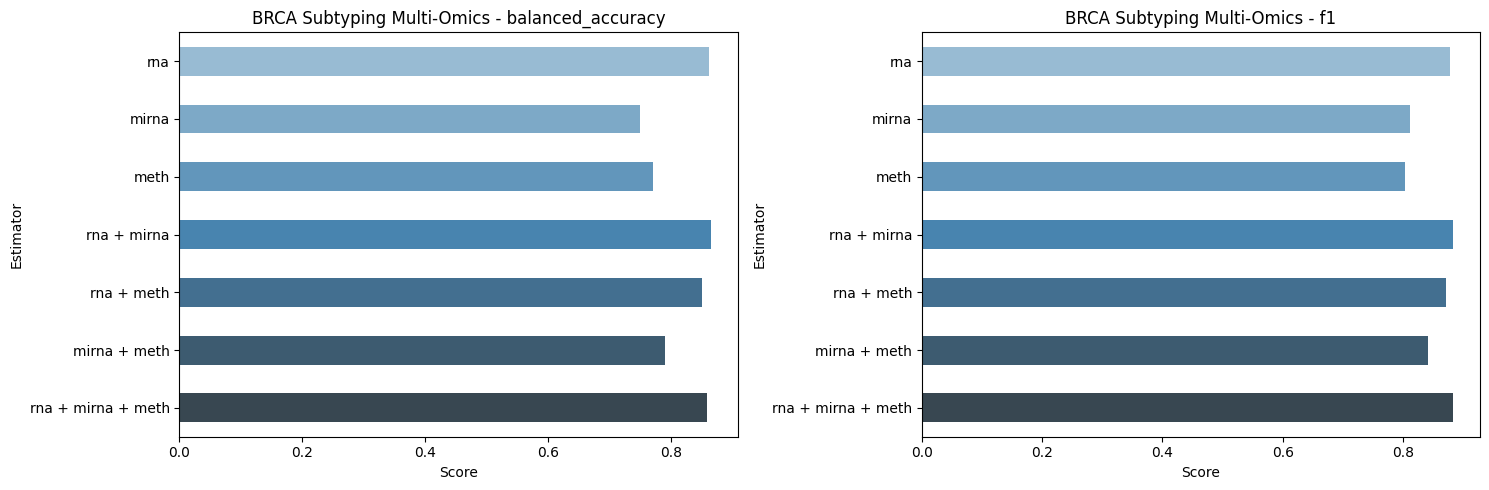

In [35]:
plot_bar_scores(names, integration_results.values(), 'BRCA Subtyping Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


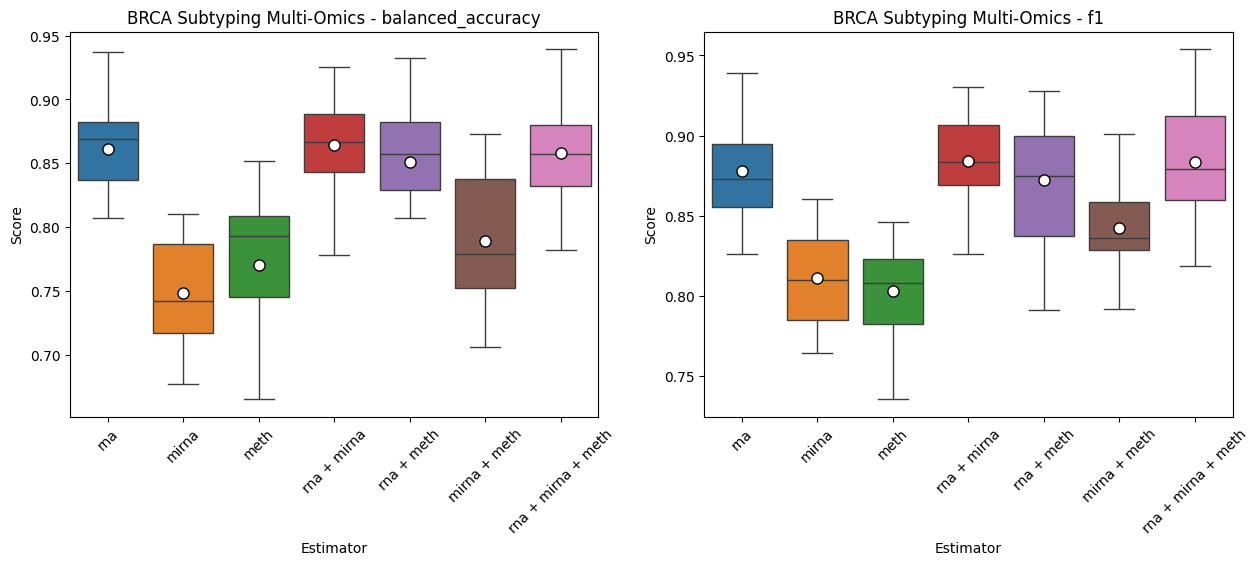

In [36]:
plot_box_scores(names, integration_results.values(), 'BRCA Subtyping Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [37]:
import json
# Convert and write JSON object to file
with open("results/brca/brca_5x3_results_final.json", "w") as outfile:
    json.dump(integration_results, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

## Feature Importance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [ ]:
# Splitting into training, validation
X_train, X_test, y_train, y_test = train_test_split(X_merged['rna + mirna + meth'], y, random_state=0, stratify=y)

In [ ]:
# Fitting on training data
meta_ensembles['rna + mirna + meth'].fit(X_train, y_train, column_names)

MultiOmicsIntegrationClassifier(cv=3,
                                estimator_dict={'methylation': ModalityPipeline(cv=3,
                                                                                estimator_list=[('logistic',
                                                                                                 Pipeline(steps=[('standardscaler',
                                                                                                                  StandardScaler()),
                                                                                                                 ('logisticregression',
                                                                                                                  LogisticRegression(max_iter=1000,
                                                                                                                                     n_jobs=-1,
                                                                                                                                     random_state=0))])),
                                                                                                ('balanced_random_forest',
                                                                                                 BalancedRandomForestClassifier(n_jobs=-1,
                                                                                                                                random_state=0,
                                                                                                                                replacement=Tr...
                                                                                        ('balanced_random_forest',
                                                                                         BalancedRandomForestClassifier(n_jobs=-1,
                                                                                                                        random_state=0,
                                                                                                                        replacement=True,
                                                                                                                        sampling_strategy='all')),
                                                                                        ('deep_nn',
                                                                                         Pipeline(steps=[('standardscaler',
                                                                                                          StandardScaler()),
                                                                                                         ('mlpclassifier',
                                                                                                          MLPClassifier(random_state=0))])),
                                                                                        ('svc',
                                                                                         Pipeline(steps=[('standardscaler',
                                                                                                          StandardScaler()),
                                                                                                         ('svc',
                                                                                                          SVC(kernel='linear',
                                                                                                              max_iter=1000,
                                                                                                              random_state=0))]))])})

In [ ]:
# Getting baseline scores
baseline_scores = {}
for name, scorer in brca_scoring.items():
  baseline_scores[name] = get_scorer(scorer)(meta_ensembles['rna + mirna + meth'], X_test, y_test)

In [ ]:
pd.DataFrame(baseline_scores, index=[""])

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
,0.944444,0.956842,0.944444,1.0,1.0,0.947368,0.88


In [ ]:
result = permutation_importance(meta_ensembles['rna + mirna + meth'], X_test, y_test, n_repeats=10, random_state=0, scoring=brca_scoring, n_jobs=-1)

In [ ]:
sorted_importances_idx = result['balanced_accuracy'].importances_mean.argsort()
importances = pd.DataFrame(
    result['balanced_accuracy'].importances[sorted_importances_idx].T,
    columns=X_merged['rna + mirna + meth'].columns[sorted_importances_idx],
)

importances.head()

,hsa-mir-361_mirna,ATXN1_meth,MEF2D_meth,IL4R_meth,SND1_meth,EMILIN2_meth,MTERFD3_meth,CDH20_meth,JPH3_meth,FGD5_meth,...,CARTPT_rna,COX8C_rna,DIO1_rna,PCGEM1_rna,S100G_rna,PIGR_rna,CRISP1_rna,ITGB6_rna,KCNK3_rna,PLUNC_rna
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


In [ ]:
importances.iloc[:, -20:].columns

Index(['ANPEP_rna', 'SLCO3A1_rna', 'BASE_rna', 'CCDC37_rna', 'MKX_rna',
       'HPX_rna', 'SERPINB5_rna', 'KRTAP3-3_rna', 'SERPINA5_rna',
       'UGT2B11_rna', 'CARTPT_rna', 'COX8C_rna', 'DIO1_rna', 'PCGEM1_rna',
       'S100G_rna', 'PIGR_rna', 'CRISP1_rna', 'ITGB6_rna', 'KCNK3_rna',
       'PLUNC_rna'],
      dtype='object')

Text(0, 0.5, 'Genes')

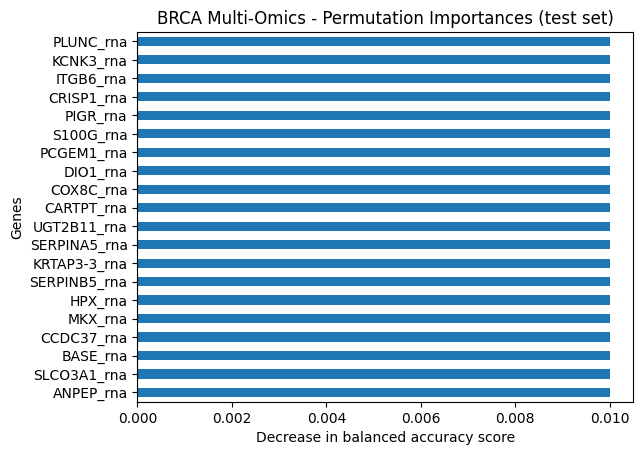

In [ ]:
# Printing top 20 important features
ax = importances.mean()[-20:].plot(kind='barh')
ax.set_title("BRCA Multi-Omics - Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in balanced accuracy score")
ax.set_ylabel('Genes')

In [ ]:
top_genes = []

for i in result['balanced_accuracy'].importances_mean.argsort()[::-1]:
     if result['balanced_accuracy'].importances_mean[i] > 0:
        top_genes.append(X_merged['rna + mirna + meth'].columns[i])
        print(f"{X_merged['rna + mirna + meth'].columns[i]:<8}  "
               f"{result['balanced_accuracy'].importances_mean[i]:.4f}"
               f" +/- {result['balanced_accuracy'].importances_std[i]:.4f}")

PLUNC_rna  0.0100 +/- 0.0000
KCNK3_rna  0.0100 +/- 0.0000
ITGB6_rna  0.0100 +/- 0.0000
CRISP1_rna  0.0100 +/- 0.0000
PIGR_rna  0.0100 +/- 0.0000
S100G_rna  0.0100 +/- 0.0000
PCGEM1_rna  0.0100 +/- 0.0000
DIO1_rna  0.0100 +/- 0.0000
COX8C_rna  0.0100 +/- 0.0000
CARTPT_rna  0.0100 +/- 0.0000
UGT2B11_rna  0.0100 +/- 0.0000
SERPINA5_rna  0.0100 +/- 0.0000
KRTAP3-3_rna  0.0100 +/- 0.0000
SERPINB5_rna  0.0100 +/- 0.0000
HPX_rna   0.0100 +/- 0.0000
MKX_rna   0.0100 +/- 0.0000
CCDC37_rna  0.0100 +/- 0.0000
BASE_rna  0.0100 +/- 0.0000
SLCO3A1_rna  0.0100 +/- 0.0000
ANPEP_rna  0.0100 +/- 0.0000
PKP1_rna  0.0090 +/- 0.0030
KRT5_rna  0.0090 +/- 0.0030
AMY1A_rna  0.0090 +/- 0.0030
PGLYRP2_rna  0.0090 +/- 0.0030
TMEM158_rna  0.0090 +/- 0.0030
LOC96610_rna  0.0090 +/- 0.0030
KRT40_rna  0.0090 +/- 0.0030
MS4A1_rna  0.0090 +/- 0.0030
SLC39A8_rna  0.0090 +/- 0.0030
MAGEB18_rna  0.0090 +/- 0.0030
TEX14_rna  0.0090 +/- 0.0030
OXTR_rna  0.0090 +/- 0.0030
TCN1_rna  0.0090 +/- 0.0030
OC90_rna  0.0090 +/- 0.0

In [ ]:
top_genes_modality = {}

for modality in datasets:
  top_genes_modality[modality] = []

for gene in top_genes:
  for modality in datasets:
    if ("_" + modality) in gene.lower():
      #top_genes_modality[modality].append(gene.removesuffix('_'+modality))
      top_genes_modality[modality].append(gene)
      break

In [ ]:
# Printing to copy-paste into top-gene for enrichment analysis
for modality in top_genes_modality:
  print(f"{modality}: " + ','.join(top_genes_modality[modality]))
  print("")

rna: PLUNC_rna,KCNK3_rna,ITGB6_rna,CRISP1_rna,PIGR_rna,S100G_rna,PCGEM1_rna,DIO1_rna,COX8C_rna,CARTPT_rna,UGT2B11_rna,SERPINA5_rna,KRTAP3-3_rna,SERPINB5_rna,HPX_rna,MKX_rna,CCDC37_rna,BASE_rna,SLCO3A1_rna,ANPEP_rna,PKP1_rna,KRT5_rna,AMY1A_rna,PGLYRP2_rna,TMEM158_rna,LOC96610_rna,KRT40_rna,MS4A1_rna,SLC39A8_rna,MAGEB18_rna,TEX14_rna,OXTR_rna,TCN1_rna,OC90_rna,C2CD4A_rna,EPHA3_rna,TUBA3D_rna,B4GALNT2_rna,KRT17_rna,GAGE12D_rna,MYO7A_rna,CDH4_rna,DHRS2_rna,DHRS9_rna,CFD_rna,GDF15_rna,GDAP2_rna,HSD3B2_rna,REPS2_rna,GAGE4_rna,AKR1D1_rna,GAGE2D_rna,CALML5_rna,ADCY1_rna,MYBPC1_rna,PRR4_rna,PRR15L_rna,FMO2_rna,SMEK3P_rna,FGL1_rna,KIAA1467_rna,SYNPO2L_rna,C20orf114_rna,C11orf30_rna,CYP4B1_rna,CYP1A1_rna,PLIN1_rna,NRAS_rna,CTSK_rna,NTS_rna,SLC38A8_rna,CRLF1_rna,SHISA2_rna,NDP_rna,COL2A1_rna,PROM1_rna,PXDNL_rna,CHRNA9_rna,CBLN2_rna,SCGB1D2_rna,SCGB1C1_rna,CD79A_rna,DCXR_rna,GPR155_rna,MAL_rna,MATN1_rna,LAMC3_rna,LCN2_rna,SPON2_rna,KIAA1383_rna,FAM65C_rna,AGXT_rna,APCDD1_rna,KERA_rna,KCNC2_rna,TF_r

In [ ]:
# Convert and write csv object to file
with open("results/brca/permutation_results.csv", "w") as outfile:
    importances.to_csv(outfile)

In [ ]:
with open("results/brca/marker_genes.json", "w") as outfile:
    json.dump(top_genes_modality, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)